In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from utils import save_gif, plot_3d_distribution

# Change to repo root directory (parent of 'analysis' folder)
# In Jupyter, we can use the notebook's directory or go up from current directory
current_dir = Path.cwd()
if current_dir.name == 'analysis':
    # If we're in the analysis folder, go up one level
    repo_root = current_dir.parent
elif 'analysis' in current_dir.parts:
    # If analysis is in the path, find repo root
    idx = current_dir.parts.index('analysis')
    repo_root = Path(*current_dir.parts[:idx])
else:
    # Otherwise, assume we're already at repo root or need to navigate
    repo_root = Path('/Users/svngo/Documents/GitHub/Dicty-Cell-Aggregation-Analysis')

os.chdir(repo_root)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/svngo/Documents/GitHub/Dicty-Cell-Aggregation-Analysis


In [2]:
# Read CSV, skipping the extra header rows (TrackMate exports have multiple header rows)
# Row 0: actual column names (keep as header)
# Row 1-3: descriptive headers we want to skip
edges_path = 'results/trial_3/20260206_224003_subset_edges.csv'
spots_path = 'results/trial_3/20260206_224003_subset_spots.csv'
edges = pd.read_csv(edges_path, header=0, skiprows=[1, 2, 3])  # Keep row 0 as header, skip rows 1-3
spots = pd.read_csv(spots_path, header=0, skiprows=[1, 2, 3])

print(f"DataFrame shape: {edges.shape}")
print(f"\nColumns: {edges.columns.tolist()}")
edges.head()

DataFrame shape: (10719, 13)

Columns: ['LABEL', 'TRACK_ID', 'SPOT_SOURCE_ID', 'SPOT_TARGET_ID', 'LINK_COST', 'DIRECTIONAL_CHANGE_RATE', 'SPEED', 'DISPLACEMENT', 'EDGE_TIME', 'EDGE_X_LOCATION', 'EDGE_Y_LOCATION', 'EDGE_Z_LOCATION', 'MANUAL_EDGE_COLOR']


LABEL  TRACK_ID  SPOT_SOURCE_ID  SPOT_TARGET_ID  LINK_COST  \
0  ID554826 → ID554635         0          554826          554635  10.479494   
1  ID555081 → ID554981         0          555081          554981  28.002000   
2  ID554981 → ID554772         0          554981          554772   0.042748   
3  ID556111 → ID556342         0          556111          556342   2.338630   
4  ID554635 → ID555081         0          554635          555081   9.016805   

   DIRECTIONAL_CHANGE_RATE     SPEED  DISPLACEMENT  EDGE_TIME  \
0                      NaN  2.472511      2.472511        0.5   
1                 0.622373  1.774840      1.774840        2.5   
2                 2.447633  1.060959      1.060959        3.5   
3                 2.840419  0.952779      0.952779        8.5   
4                 2.855178  0.461510      0.461510        1.5   

   EDGE_X_LOCATION  EDGE_Y_LOCATION  EDGE_Z_LOCATION  MANUAL_EDGE_COLOR  
0       190.847919       249.699022              0.0                NaN  
1       191.006070       249.642027              0.0                NaN  
2       191.593560       249.646044              0.0                NaN  
3       191.788058       250.393479              0.0                NaN  
4       190.211231       248.905988              0.0                NaN

In [3]:
spots.head()

LABEL      ID  TRACK_ID  QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0  ID555081  555081         0    256.0  190.285113  249.124595         0.0   
1  ID554826  554826         0    321.0  191.558489  250.710663         0.0   
2  ID555274  555274         0    261.0  191.494220  250.146757         0.0   
3  ID557258  557258         0    298.0  193.309764  250.383838         0.0   
4  ID554635  554635         0    261.0  190.137349  248.687380         0.0   

   POSITION_T  FRAME     RADIUS  ...  ELLIPSE_Y0  ELLIPSE_MAJOR  \
0         2.0      2   9.053441  ...    0.312021      10.501882   
1         0.0      0  10.124020  ...    0.327645      13.686488   
2         5.0      5   9.088532  ...    0.143661      11.585449   
3        16.0     16   9.723067  ...    0.411175      12.673752   
4         1.0      1   9.123488  ...   -0.032827      10.472385   

   ELLIPSE_MINOR  ELLIPSE_THETA  ELLIPSE_ASPECTRATIO   AREA  PERIMETER  \
0       8.393338       1.116109             1.251216  257.5  69.509440   
1       7.861003       0.975135             1.741061  322.0  86.968336   
2       7.554834       0.967845             1.533515  259.5  84.043829   
3       8.003717       0.935217             1.583483  297.0  85.337007   
4       8.168952       1.146933             1.281974  261.5  71.671677   

   CIRCULARITY  SOLIDITY  SHAPE_INDEX  
0     0.669730  0.894097     4.331668  
1     0.534987  0.824584     4.846556  
2     0.461674  0.803406     5.217196  
3     0.512497  0.838983     4.951755  
4     0.639715  0.874582     4.432122  

[5 rows x 31 columns]

## Merge Edges with Spots
- Inner joins to get positions and times of the target spots and source spots for each row

In [4]:
# merge edges with spots twice

# Select only the columns we need from spots (position and time)
spot_cols_needed = ['ID', 'POSITION_X', 'POSITION_Y', 'POSITION_T']

# First merge: get source spot positions
merged = edges.merge(
    spots[spot_cols_needed], 
    left_on='SPOT_SOURCE_ID', 
    right_on='ID', 
    how='inner'
)
# Rename the position/time columns to have '_source' suffix
merged = merged.rename(columns={
    'POSITION_X': 'POSITION_X_source',
    'POSITION_Y': 'POSITION_Y_source', 
    'POSITION_T': 'POSITION_T_source'
})
# Drop the 'ID' column from spots (we don't need it anymore)
merged = merged.drop(columns=['ID'])

# Second merge: get target spot positions
merged = merged.merge(
    spots[spot_cols_needed], 
    left_on='SPOT_TARGET_ID', 
    right_on='ID', 
    how='inner'
)
# Rename the position/time columns to have '_target' suffix
merged = merged.rename(columns={
    'POSITION_X': 'POSITION_X_target',
    'POSITION_Y': 'POSITION_Y_target',
    'POSITION_T': 'POSITION_T_target'
})
# Drop the 'ID' column again
merged = merged.drop(columns=['ID'])

In [5]:
merged.head().iloc[:, -6:]

POSITION_X_source  POSITION_Y_source  POSITION_T_source  POSITION_X_target  \
0         191.558489         250.710663                0.0         190.137349   
1         190.285113         249.124595                2.0         191.727027   
2         191.727027         250.159459                3.0         191.460094   
3         191.419975         250.091052                8.0         192.156140   
4         190.137349         248.687380                1.0         190.285113   

   POSITION_Y_target  POSITION_T_target  
0         248.687380                1.0  
1         250.159459                3.0  
2         249.132629                4.0  
3         250.695906                9.0  
4         249.124595                2.0

## Calculate Velocity Components
- Note: Units are currently in pixels per frame

In [6]:
delta_T = merged['POSITION_T_target'] - merged['POSITION_T_source']
# Fix: Need parentheses around the position difference before dividing by delta_T
merged['V_x'] = (merged['POSITION_X_target'] - merged['POSITION_X_source']) / delta_T
merged['V_y'] = (merged['POSITION_Y_target'] - merged['POSITION_Y_source']) / delta_T

In [7]:
merged.head()

LABEL  TRACK_ID  SPOT_SOURCE_ID  SPOT_TARGET_ID  LINK_COST  \
0  ID554826 → ID554635         0          554826          554635  10.479494   
1  ID555081 → ID554981         0          555081          554981  28.002000   
2  ID554981 → ID554772         0          554981          554772   0.042748   
3  ID556111 → ID556342         0          556111          556342   2.338630   
4  ID554635 → ID555081         0          554635          555081   9.016805   

   DIRECTIONAL_CHANGE_RATE     SPEED  DISPLACEMENT  EDGE_TIME  \
0                      NaN  2.472511      2.472511        0.5   
1                 0.622373  1.774840      1.774840        2.5   
2                 2.447633  1.060959      1.060959        3.5   
3                 2.840419  0.952779      0.952779        8.5   
4                 2.855178  0.461510      0.461510        1.5   

   EDGE_X_LOCATION  ...  EDGE_Z_LOCATION  MANUAL_EDGE_COLOR  \
0       190.847919  ...              0.0                NaN   
1       191.006070  ...              0.0                NaN   
2       191.593560  ...              0.0                NaN   
3       191.788058  ...              0.0                NaN   
4       190.211231  ...              0.0                NaN   

   POSITION_X_source  POSITION_Y_source  POSITION_T_source  POSITION_X_target  \
0         191.558489         250.710663                0.0         190.137349   
1         190.285113         249.124595                2.0         191.727027   
2         191.727027         250.159459                3.0         191.460094   
3         191.419975         250.091052                8.0         192.156140   
4         190.137349         248.687380                1.0         190.285113   

   POSITION_Y_target  POSITION_T_target       V_x       V_y  
0         248.687380                1.0 -1.421140 -2.023282  
1         250.159459                3.0  1.441914  1.034864  
2         249.132629                4.0 -0.266933 -1.026830  
3         250.695906                9.0  0.736166  0.604854  
4         249.124595                2.0  0.147765  0.437215  

[5 rows x 21 columns]

In [8]:
# validate VELOCITY == SPEED 
merged['VELOCITY'] = np.sqrt(merged['V_x'] ** 2 + merged['V_y'] ** 2)
print('Magnitude of velocity and speed are equal: ' + str(all(np.isclose(np.abs(merged['VELOCITY']), merged['SPEED'], rtol=1e-05))))

Magnitude of velocity and speed are equal: True


## Image Coordinate System to Standard Coordinate System
ImageJ/TrackMate uses image coordinates, not mathematical coordinates:
- Origin (0, 0) is at the top-left corner of the image
- X-axis: increases to the right (positive = right, negative = left)
- Y-axis: increases downward (positive = down, negative = up)

### 1. Convert velocity components to correct units

In [9]:
# 1 pixel = 3.731309 μm
# 1 frame = 15 seconds (from README)
pixel_to_micron = 3.731309
seconds_per_frame = 15
merged['V_x'] = merged['V_x'] * pixel_to_micron / seconds_per_frame 
merged['V_y'] = merged['V_y'] * pixel_to_micron / seconds_per_frame * -1 # negate y for the standard coordinate system

### 2. Get wave velocity direction

In [10]:
# unit vector direction components of the wave
wave_x_unit = -0.875
wave_y_unit = -0.485

### 3. Compute Cosine between velocity and wave (dot product)

In [11]:
# Normalize velocity to unit vector
V_x = merged['V_x']
V_y = merged['V_y']

velocity_magnitude = np.sqrt(V_x**2 + V_y**2)
V_x_unit = V_x / velocity_magnitude
V_y_unit = V_y / velocity_magnitude

# Dot product with wave unit vector
merged['cosine'] = V_x_unit * wave_x_unit + V_y_unit * wave_y_unit

# Sort by closest to 1 (most aligned)
sorted_by_alignment = merged.sort_values('cosine', ascending=False)
sorted_by_alignment['cosine']

10583    1.000424
8100     1.000424
1906     1.000424
1623     1.000424
5030     1.000423
           ...   
1166    -1.000424
2447    -1.000424
460     -1.000424
8040    -1.000425
5127    -1.000425
Name: cosine, Length: 10719, dtype: float64

# Exploratory Data Analysis

## Cosine Analysis

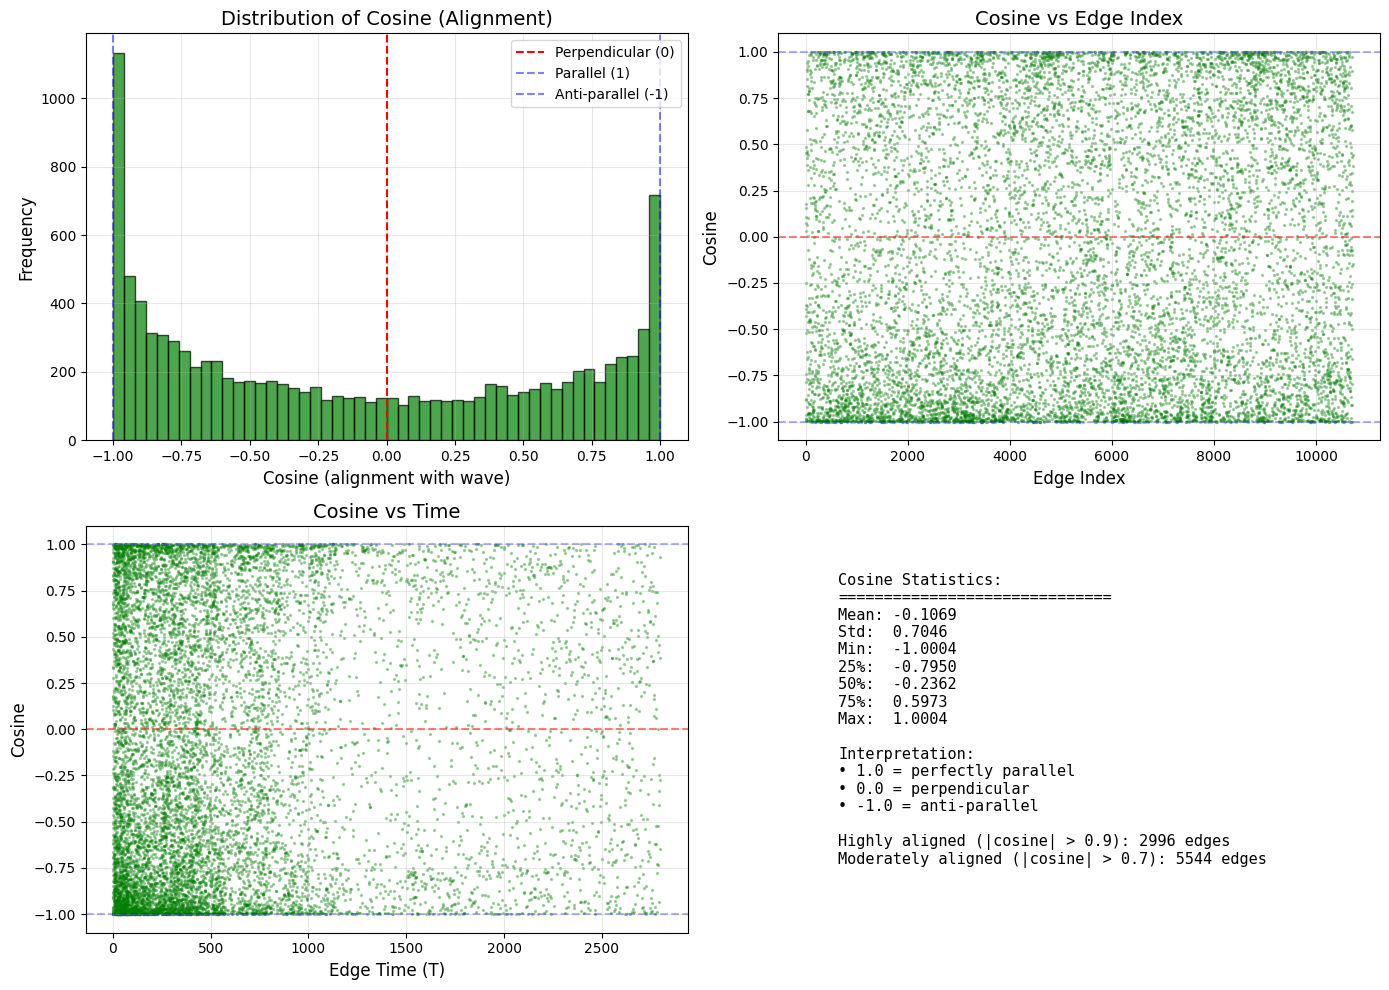

In [12]:
# Visualize cosine (alignment with wave direction)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of cosine values
axes[0, 0].hist(merged['cosine'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 0].set_xlabel('Cosine (alignment with wave)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Cosine (Alignment)', fontsize=14)
axes[0, 0].axvline(0, color='red', linestyle='--', label='Perpendicular (0)')
axes[0, 0].axvline(1, color='blue', linestyle='--', alpha=0.5, label='Parallel (1)')
axes[0, 0].axvline(-1, color='blue', linestyle='--', alpha=0.5, label='Anti-parallel (-1)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Cosine vs Edge Index
axes[0, 1].scatter(merged.index, merged['cosine'], alpha=0.3, s=2, color='green')
axes[0, 1].set_xlabel('Edge Index', fontsize=12)
axes[0, 1].set_ylabel('Cosine', fontsize=12)
axes[0, 1].set_title('Cosine vs Edge Index', fontsize=14)
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(1, color='blue', linestyle='--', alpha=0.3)
axes[0, 1].axhline(-1, color='blue', linestyle='--', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# Cosine vs Time
if 'EDGE_TIME' in merged.columns:
    T = merged['EDGE_TIME']
    time_label = 'Edge Time (T)'
else:
    T = (merged['POSITION_T_source'] + merged['POSITION_T_target']) / 2
    time_label = 'Time (T) - Midpoint'

axes[1, 0].scatter(T, merged['cosine'], alpha=0.3, s=2, color='green')
axes[1, 0].set_xlabel(time_label, fontsize=12)
axes[1, 0].set_ylabel('Cosine', fontsize=12)
axes[1, 0].set_title('Cosine vs Time', fontsize=14)
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axhline(1, color='blue', linestyle='--', alpha=0.3)
axes[1, 0].axhline(-1, color='blue', linestyle='--', alpha=0.3)
axes[1, 0].grid(True, alpha=0.3)

# Statistics summary
cosine_stats = merged['cosine'].describe()
axes[1, 1].axis('off')
stats_text = f"""Cosine Statistics:
{'='*30}
Mean: {cosine_stats['mean']:.4f}
Std:  {cosine_stats['std']:.4f}
Min:  {cosine_stats['min']:.4f}
25%:  {cosine_stats['25%']:.4f}
50%:  {cosine_stats['50%']:.4f}
75%:  {cosine_stats['75%']:.4f}
Max:  {cosine_stats['max']:.4f}

Interpretation:
• 1.0 = perfectly parallel
• 0.0 = perpendicular
• -1.0 = anti-parallel

Highly aligned (|cosine| > 0.9): {((merged['cosine'].abs() > 0.9).sum())} edges
Moderately aligned (|cosine| > 0.7): {((merged['cosine'].abs() > 0.7).sum())} edges
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
                verticalalignment='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

Since the wave propagates down and to the left, it would make sense for the **cosine of the instantaneous edge velocities** to be *more* negative, as it should move not with the wave but in the opposite direction of the wave, towards its origin (top right). Any amount of **anti-parallelism** is what we're looking for.

We should also use a technique for noise removal and sparsity handling.

## Parallelism and Orthogonality Analysis

In [13]:
# Parallel component (along wave direction)
merged['V_parallel'] = V_x * wave_x_unit + V_y * wave_y_unit

# Orthogonal component (projection/perpendicular to wave)
merged['V_orthogonal'] = V_x * (-wave_y_unit) + V_y * wave_x_unit  # rotate wave vector 90°

In [14]:
# Extract V_parallel and V_orthogonal as Series
V_parallel = merged['V_parallel']
V_orthogonal = merged['V_orthogonal']

print(f"V_parallel: {len(V_parallel)} values")
print(f"V_orthogonal: {len(V_orthogonal)} values")
print(f"\nV_parallel stats:")
print(V_parallel.describe())
print(f"\nV_orthogonal stats:")
print(V_orthogonal.describe())

V_parallel: 10719 values
V_orthogonal: 10719 values

V_parallel stats:
count    10719.000000
mean        -0.017521
std          0.225962
min         -4.520296
25%         -0.085466
50%         -0.015807
75%          0.049443
max          4.147707
Name: V_parallel, dtype: float64

V_orthogonal stats:
count    10719.000000
mean         0.000543
std          0.216486
min         -4.021742
25%         -0.067162
50%         -0.000768
75%          0.068690
max          3.011412
Name: V_orthogonal, dtype: float64


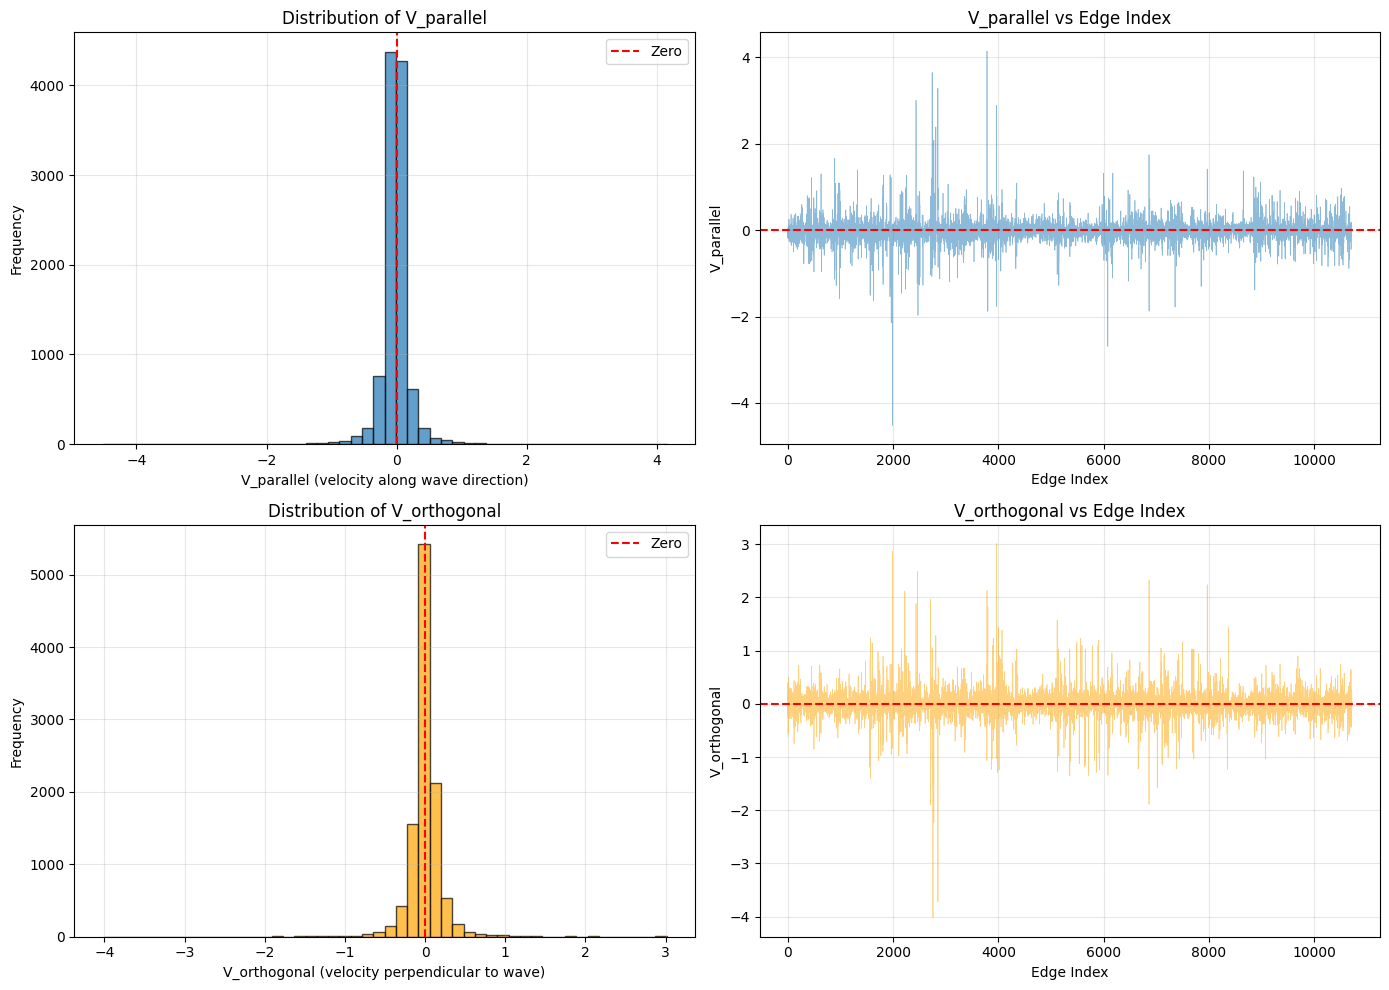

In [15]:
# Create plots for V_parallel and V_orthogonal
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# V_parallel plots
axes[0, 0].hist(V_parallel, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('V_parallel (velocity along wave direction)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of V_parallel')
axes[0, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(V_parallel.index, V_parallel.values, alpha=0.5, linewidth=0.5)
axes[0, 1].set_xlabel('Edge Index')
axes[0, 1].set_ylabel('V_parallel')
axes[0, 1].set_title('V_parallel vs Edge Index')
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].grid(True, alpha=0.3)

# V_orthogonal plots
axes[1, 0].hist(V_orthogonal, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('V_orthogonal (velocity perpendicular to wave)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of V_orthogonal')
axes[1, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(V_orthogonal.index, V_orthogonal.values, alpha=0.5, linewidth=0.5, color='orange')
axes[1, 1].set_xlabel('Edge Index')
axes[1, 1].set_ylabel('V_orthogonal')
axes[1, 1].set_title('V_orthogonal vs Edge Index')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

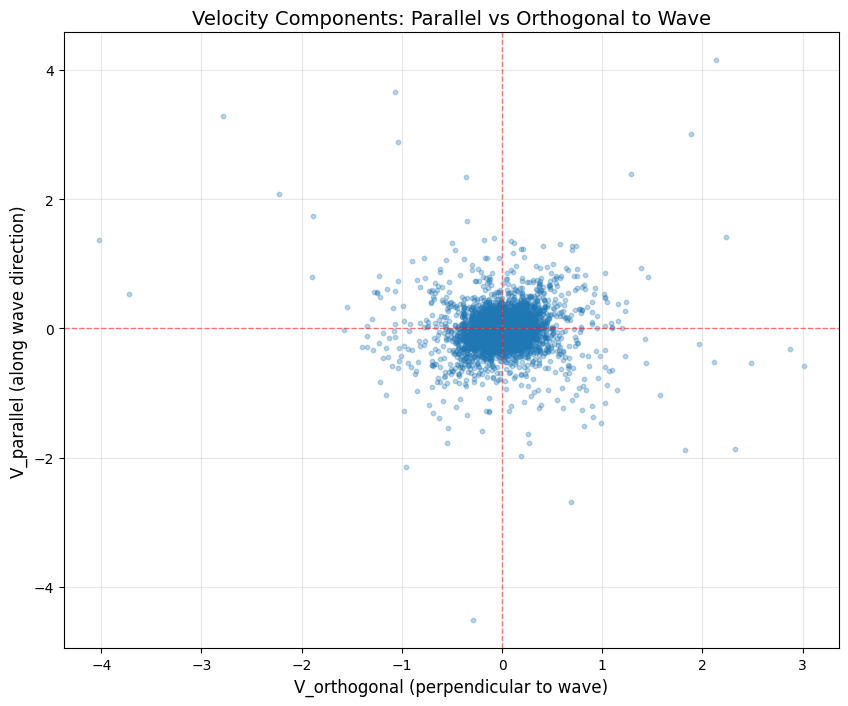

Quadrant Analysis:
Q1 (V_orthogonal > 0, V_parallel > 0): 2528 edges
Q2 (V_orthogonal < 0, V_parallel > 0): 2113 edges
Q3 (V_orthogonal < 0, V_parallel < 0): 3278 edges
Q4 (V_orthogonal > 0, V_parallel < 0): 2800 edges


In [16]:
# Scatter plot: V_parallel vs V_orthogonal
plt.figure(figsize=(10, 8))
plt.scatter(V_orthogonal, V_parallel, alpha=0.3, s=10)
plt.xlabel('V_orthogonal (perpendicular to wave)', fontsize=12)
plt.ylabel('V_parallel (along wave direction)', fontsize=12)
plt.title('Velocity Components: Parallel vs Orthogonal to Wave', fontsize=14)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

# Print quadrant analysis
print("Quadrant Analysis:")
print(f"Q1 (V_orthogonal > 0, V_parallel > 0): {((V_orthogonal > 0) & (V_parallel > 0)).sum()} edges")
print(f"Q2 (V_orthogonal < 0, V_parallel > 0): {((V_orthogonal < 0) & (V_parallel > 0)).sum()} edges")
print(f"Q3 (V_orthogonal < 0, V_parallel < 0): {((V_orthogonal < 0) & (V_parallel < 0)).sum()} edges")
print(f"Q4 (V_orthogonal > 0, V_parallel < 0): {((V_orthogonal > 0) & (V_parallel < 0)).sum()} edges")

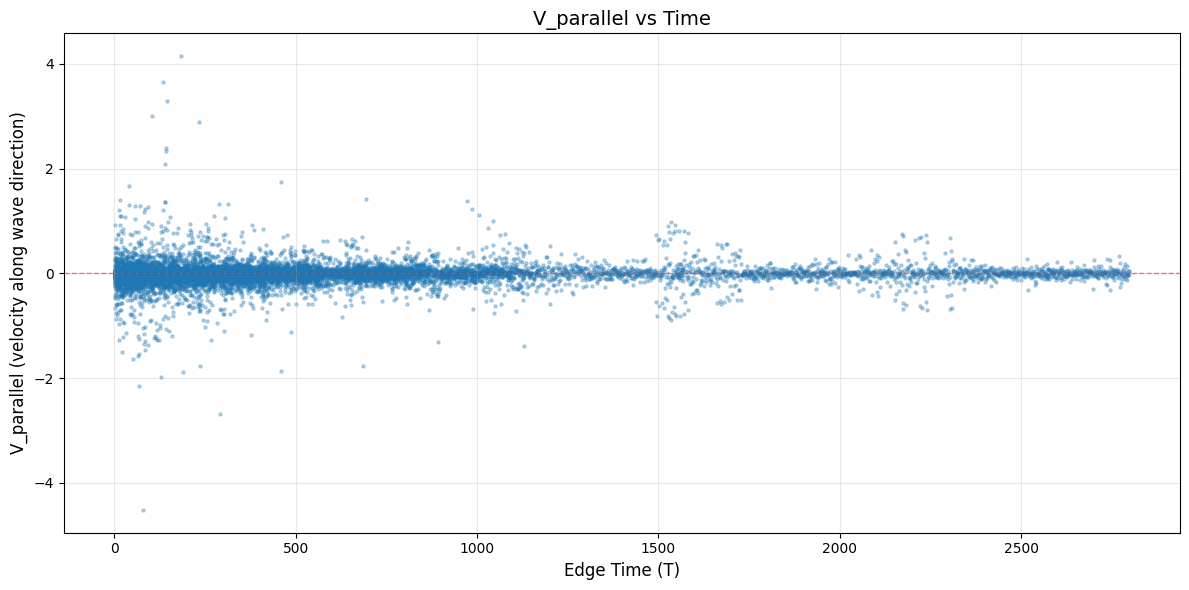

In [17]:
# Use EDGE_TIME if available, otherwise use average of source and target times
if 'EDGE_TIME' in merged.columns:
    T = merged['EDGE_TIME']
    time_label = 'Edge Time (T)'
else:
    # Use midpoint time between source and target
    T = (merged['POSITION_T_source'] + merged['POSITION_T_target']) / 2
    time_label = 'Time (T) - Midpoint'

# Plot V_parallel vs Time
plt.figure(figsize=(12, 6))
plt.scatter(T, V_parallel.values, alpha=0.3, s=5)
plt.xlabel(time_label, fontsize=12)
plt.ylabel('V_parallel (velocity along wave direction)', fontsize=12)
plt.title('V_parallel vs Time', fontsize=14)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Futher Cosine Analysis

For each track and time bin, compute the average cosine across its edges. We create a 2D array, such that heatmap **H[track_index, time_bin] = mean cosine**. We then show the heatmap to see when each track tends to align with the wave. Overall, blue is best.

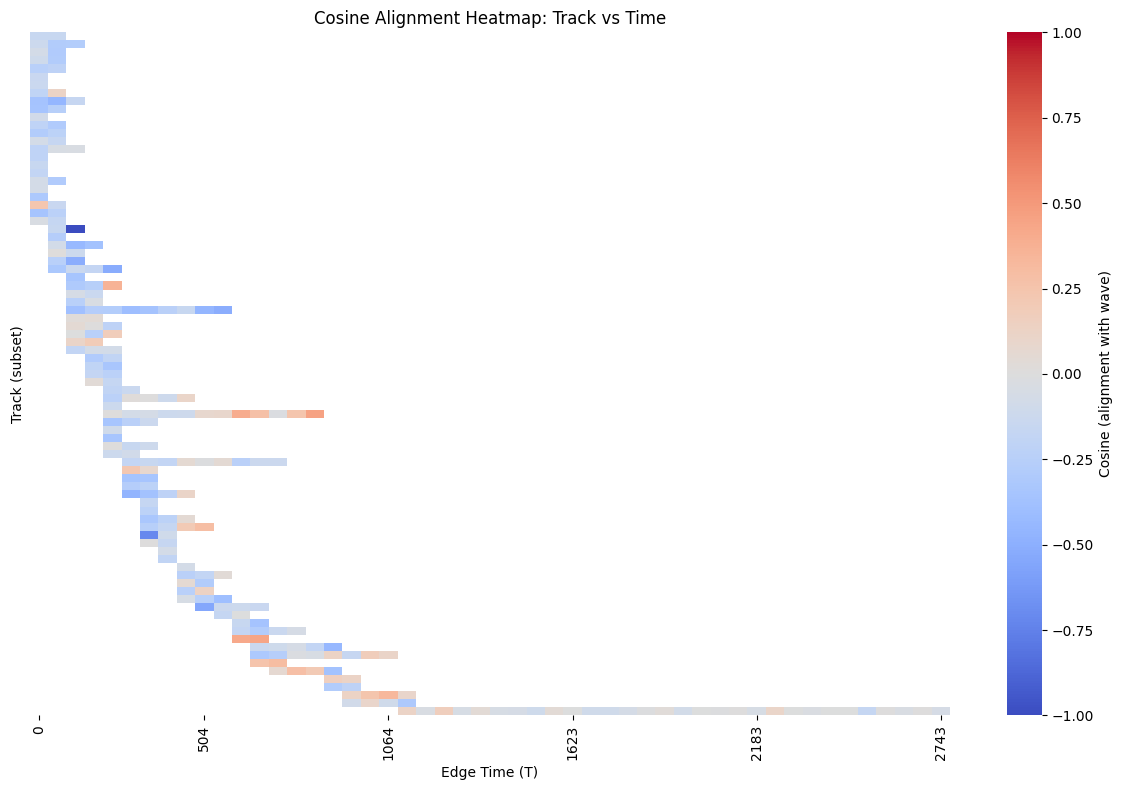

In [18]:
# Heatmap 1: Cosine vs Time vs Track ID

# Choose time axis
if 'EDGE_TIME' in merged.columns:
    time_vals = merged['EDGE_TIME']
    time_label = 'Edge Time (T)'
else:
    time_vals = (merged['POSITION_T_source'] + merged['POSITION_T_target']) / 2
    time_label = 'Time (T) - Midpoint'

# Bin time into, say, 50 bins
n_time_bins = 50
time_bins = np.linspace(time_vals.min(), time_vals.max(), n_time_bins + 1)
merged['time_bin'] = np.digitize(time_vals, time_bins) - 1

# Limit to tracks with enough edges to show structure
min_edges_per_track = 20
track_counts = merged['TRACK_ID'].value_counts()
valid_tracks = track_counts[track_counts >= min_edges_per_track].index

subset = merged[merged['TRACK_ID'].isin(valid_tracks)].copy()

# Map track IDs to consecutive row indices
track_id_to_row = {tid: i for i, tid in enumerate(sorted(valid_tracks))}
subset['track_row'] = subset['TRACK_ID'].map(track_id_to_row)

# Initialize heatmap array with NaNs
heat = np.full((len(valid_tracks), n_time_bins), np.nan)

# Fill with mean cosine per (track_row, time_bin)
for (row, tbin), group in subset.groupby(['track_row', 'time_bin']):
    if 0 <= tbin < n_time_bins:
        heat[row, tbin] = group['cosine'].mean()

plt.figure(figsize=(12, 8))
# Use a diverging colormap centered at 0
sns.heatmap(
    heat,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Cosine (alignment with wave)'}
)
plt.xlabel(time_label)
plt.ylabel('Track (subset)')
plt.title('Cosine Alignment Heatmap: Track vs Time')
# Approximate time tick labels
xticks = np.linspace(0, n_time_bins - 1, 6, dtype=int)
xtick_labels = [f"{time_bins[i]:.0f}" for i in xticks]
plt.xticks(xticks + 0.5, xtick_labels)
plt.yticks([])
plt.tight_layout()
plt.show()

We also bin time on one axis and cosine on the other, filling each cell with the count or density of edges in that (time, cosine) bin. This shows how the distribution of alignment evolves over time.

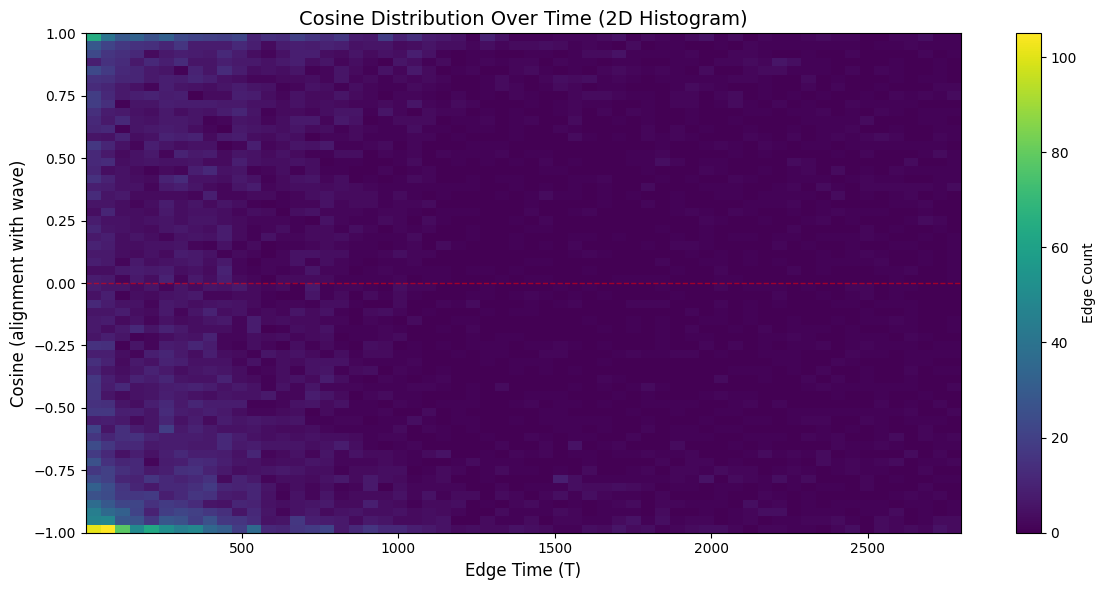

In [19]:
# Heatmap 2: Time vs Cosine distribution (2D histogram)

# Reuse time_vals from previous cell
if 'EDGE_TIME' in merged.columns:
    time_vals = merged['EDGE_TIME']
    time_label = 'Edge Time (T)'
else:
    time_vals = (merged['POSITION_T_source'] + merged['POSITION_T_target']) / 2
    time_label = 'Time (T) - Midpoint'

cos_vals = merged['cosine'].values

# Define bins
n_time_bins = 60
n_cos_bins = 60
time_bins = np.linspace(time_vals.min(), time_vals.max(), n_time_bins + 1)
cos_bins = np.linspace(-1, 1, n_cos_bins + 1)

# Compute 2D histogram: counts of edges in each (time, cosine) bin
H, xedges, yedges = np.histogram2d(time_vals, cos_vals, bins=[time_bins, cos_bins])

plt.figure(figsize=(12, 6))
# Transpose H so cosine is vertical axis
plt.imshow(
    H.T,
    aspect='auto',
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='viridis'
)
plt.colorbar(label='Edge Count')
plt.xlabel(time_label, fontsize=12)
plt.ylabel('Cosine (alignment with wave)', fontsize=12)
plt.title('Cosine Distribution Over Time (2D Histogram)', fontsize=14)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(1, color='white', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(-1, color='white', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

### 3D Bimodal Distribution Density Visualizations


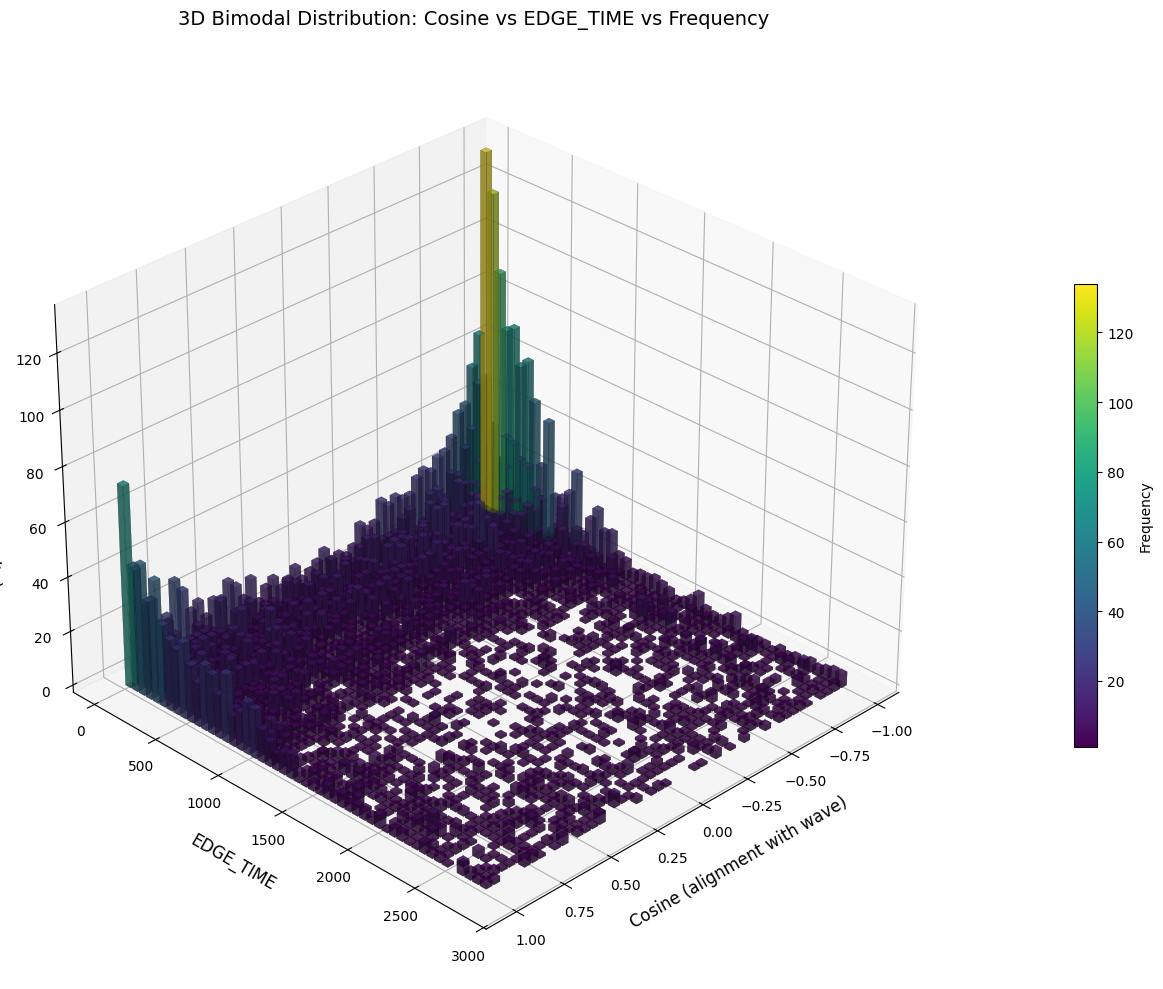


Statistics:
Total edges: 10719
Cosine range: [-1.000, 1.000]
EDGE_TIME range: [0.50, 2798.50]
Max frequency in bin: 134.0
Bins with data: 1934 / 2500


In [20]:
# 3D Bimodal Distribution: Cosine vs Feature vs Frequency
from mpl_toolkits.mplot3d import Axes3D

# Choose feature to plot (EDGE_TIME, V_parallel, SPEED, etc.)
feature_name = 'EDGE_TIME'  # Change this to try different features
feature_data = merged[feature_name].values
cosine_data = merged['cosine'].values

# Create bins for histogram
n_cosine_bins = 50
n_feature_bins = 50

cosine_bins = np.linspace(-1, 1, n_cosine_bins + 1)
feature_bins = np.linspace(feature_data.min(), feature_data.max(), n_feature_bins + 1)

# Compute 2D histogram
H, cosine_edges, feature_edges = np.histogram2d(
    cosine_data, 
    feature_data, 
    bins=[cosine_bins, feature_bins]
)

# Get bin centers for plotting
cosine_centers = (cosine_edges[:-1] + cosine_edges[1:]) / 2
feature_centers = (feature_edges[:-1] + feature_edges[1:]) / 2

# Create meshgrid for 3D surface
Cosine_mesh, Feature_mesh = np.meshgrid(cosine_centers, feature_centers, indexing='ij')

# Create 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot as 3D bar chart (histogram bars)
# Only plot bars where frequency > 0 to reduce clutter
nonzero_mask = H > 0
x_pos = Cosine_mesh[nonzero_mask]
y_pos = Feature_mesh[nonzero_mask]
z_pos = np.zeros_like(x_pos)
dx = (cosine_edges[1] - cosine_edges[0]) * 0.8  # Bar width (80% of bin)
dy = (feature_edges[1] - feature_edges[0]) * 0.8
dz = H[nonzero_mask]

# Color bars by frequency (density)
colors = plt.cm.viridis(dz / dz.max())

# Create 3D bar plot
ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=colors, alpha=0.6, edgecolor='black', linewidth=0.1)

ax.set_xlabel('Cosine (alignment with wave)', fontsize=12, labelpad=10)
ax.set_ylabel(f'{feature_name}', fontsize=12, labelpad=10)
ax.set_zlabel('Frequency (Density)', fontsize=12, labelpad=10)
ax.set_title(f'3D Bimodal Distribution: Cosine vs {feature_name} vs Frequency', fontsize=14, pad=20)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=dz.min(), vmax=dz.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=20, pad=0.1)
cbar.set_label('Frequency', fontsize=10)

# Set viewing angle
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nStatistics:")
print(f"Total edges: {len(merged)}")
print(f"Cosine range: [{cosine_data.min():.3f}, {cosine_data.max():.3f}]")
print(f"{feature_name} range: [{feature_data.min():.2f}, {feature_data.max():.2f}]")
print(f"Max frequency in bin: {H.max()}")
print(f"Bins with data: {np.sum(H > 0)} / {H.size}")

In [21]:
# Helper function to create 3D distribution plots for any feature combination
from utils import plot_3d_distribution
print("Helper function 'plot_3d_distribution' created!")
print("\nUsage:")
print("  plot_3d_distribution('feature1', 'feature2', merged)  # Shows both bar and surface")
print("  plot_3d_distribution('feature1', 'feature2', merged, plot_type='bar')  # Bar chart only")
print("  plot_3d_distribution('feature1', 'feature2', merged, plot_type='surface')  # Surface only")

Helper function 'plot_3d_distribution' created!

Usage:
  plot_3d_distribution('feature1', 'feature2', merged)  # Shows both bar and surface
  plot_3d_distribution('feature1', 'feature2', merged, plot_type='bar')  # Bar chart only
  plot_3d_distribution('feature1', 'feature2', merged, plot_type='surface')  # Surface only


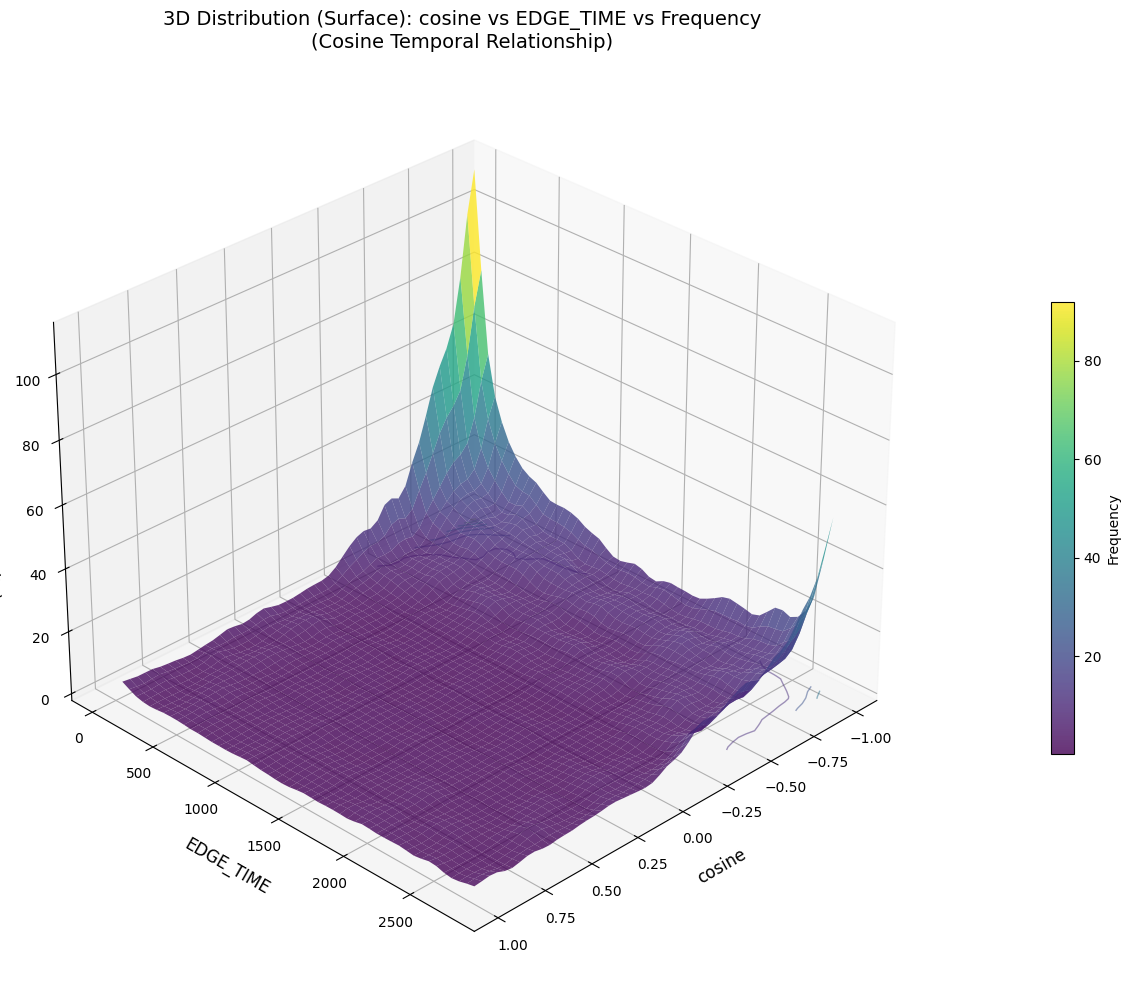


Statistics for cosine vs EDGE_TIME:
Total data points: 10719
cosine range: [-1.000, 1.000]
EDGE_TIME range: [0.500, 2798.500]
Max frequency in bin: 152.0
Bins with data: 1935 / 2500


In [22]:
plot_3d_distribution('cosine', 'EDGE_TIME', merged, 
                     n_bins1=50, n_bins2=50, plot_type='surface',
                     title_suffix="\n(Cosine Temporal Relationship)")

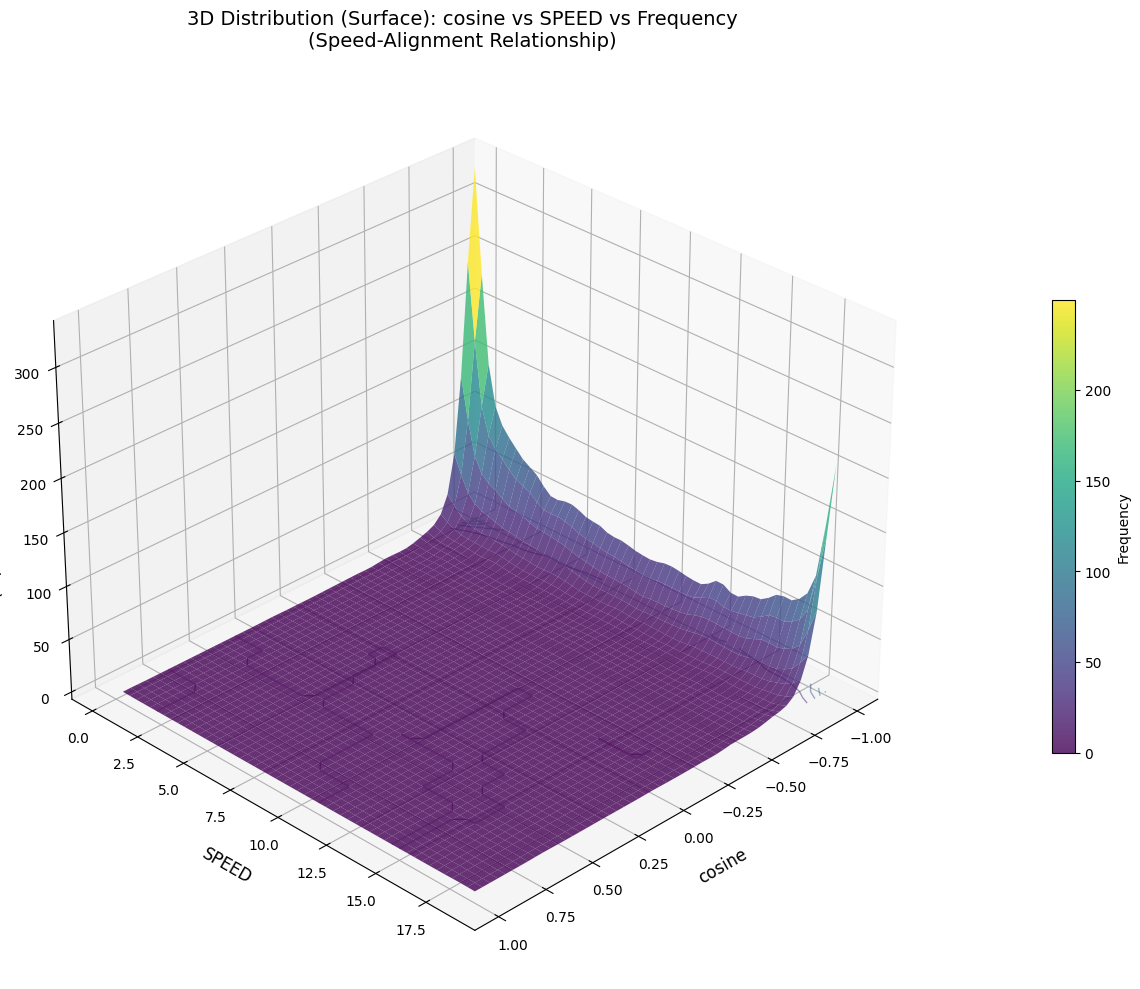


Statistics for cosine vs SPEED:
Total data points: 10719
cosine range: [-1.000, 1.000]
SPEED range: [0.003, 18.741]
Max frequency in bin: 501.0
Bins with data: 600 / 2500


In [23]:
# Shows if faster cells align better with the wave
plot_3d_distribution('cosine', 'SPEED', merged, 
                     n_bins1=50, n_bins2=50, plot_type='surface',
                     title_suffix="\n(Speed-Alignment Relationship)")

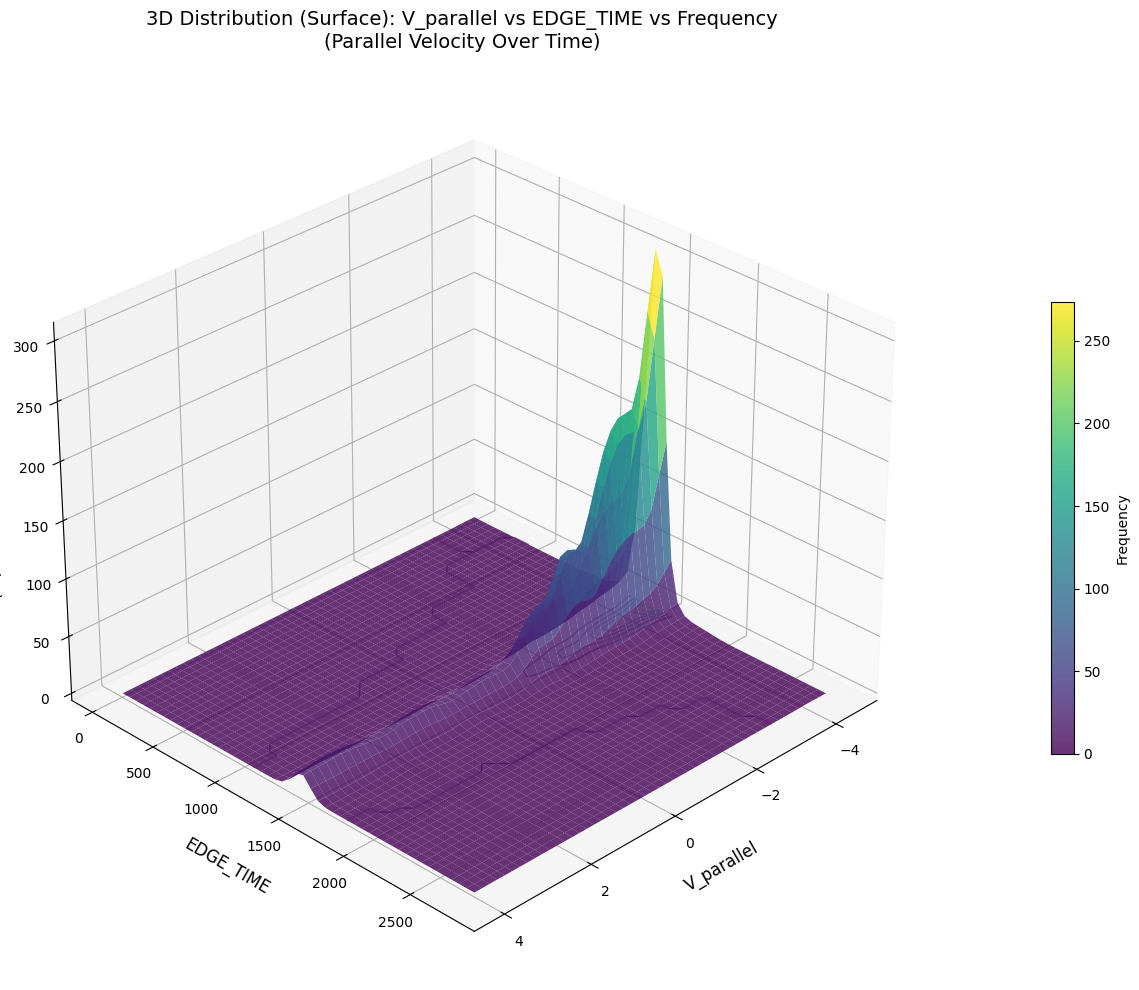


Statistics for V_parallel vs EDGE_TIME:
Total data points: 10719
V_parallel range: [-4.520, 4.148]
EDGE_TIME range: [0.500, 2798.500]
Max frequency in bin: 520.0
Bins with data: 396 / 2500


In [24]:
# Shows how parallel velocity changes over time
plot_3d_distribution('V_parallel', 'EDGE_TIME', merged, 
                     n_bins1=50, n_bins2=50, plot_type='surface',
                     title_suffix="\n(Parallel Velocity Over Time)")

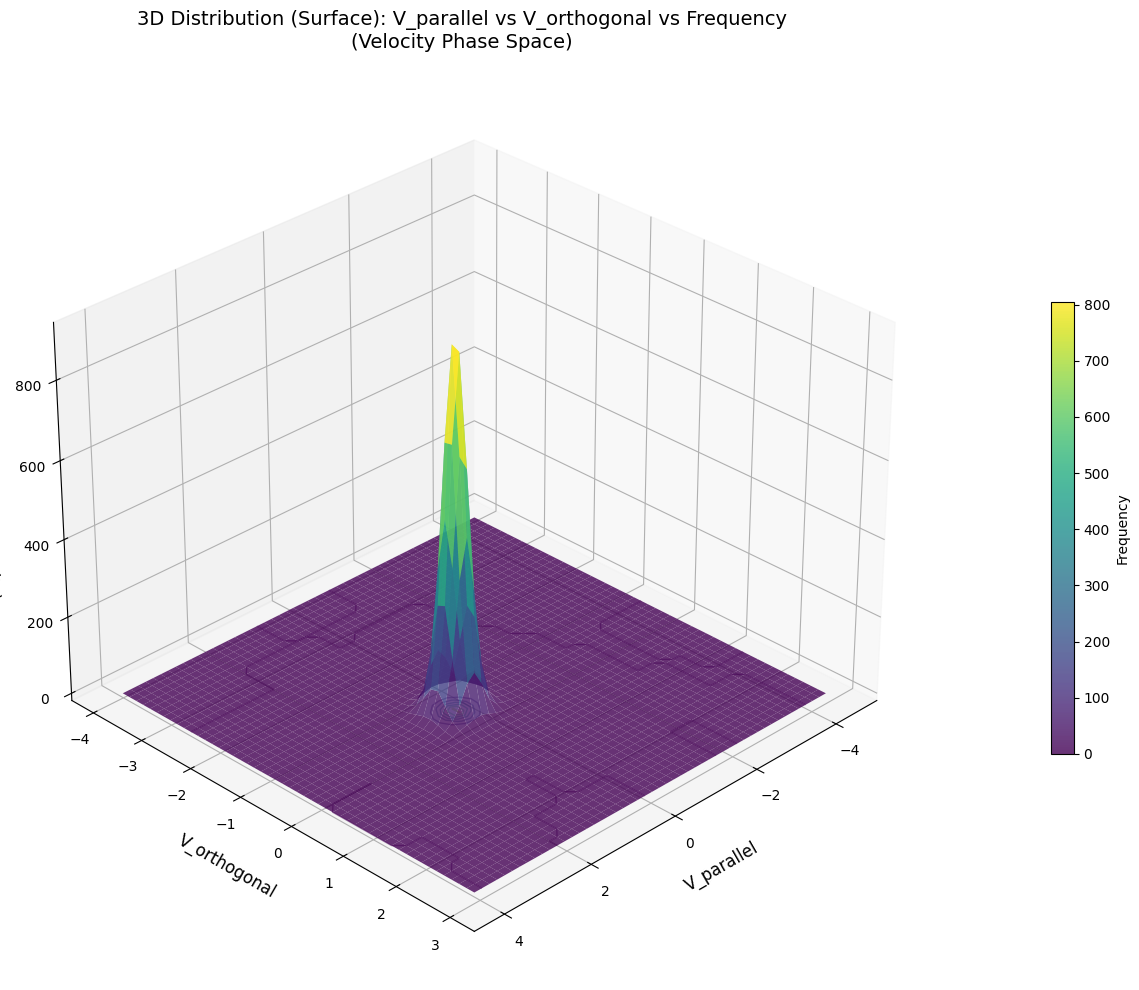


Statistics for V_parallel vs V_orthogonal:
Total data points: 10719
V_parallel range: [-4.520, 4.148]
V_orthogonal range: [-4.022, 3.011]
Max frequency in bin: 2496.0
Bins with data: 258 / 2500


In [25]:
# Shows velocity phase space - how do cells move in parallel vs perpendicular?
plot_3d_distribution('V_parallel', 'V_orthogonal', merged, 
                     n_bins1=50, n_bins2=50, plot_type='surface',
                     title_suffix="\n(Velocity Phase Space)")

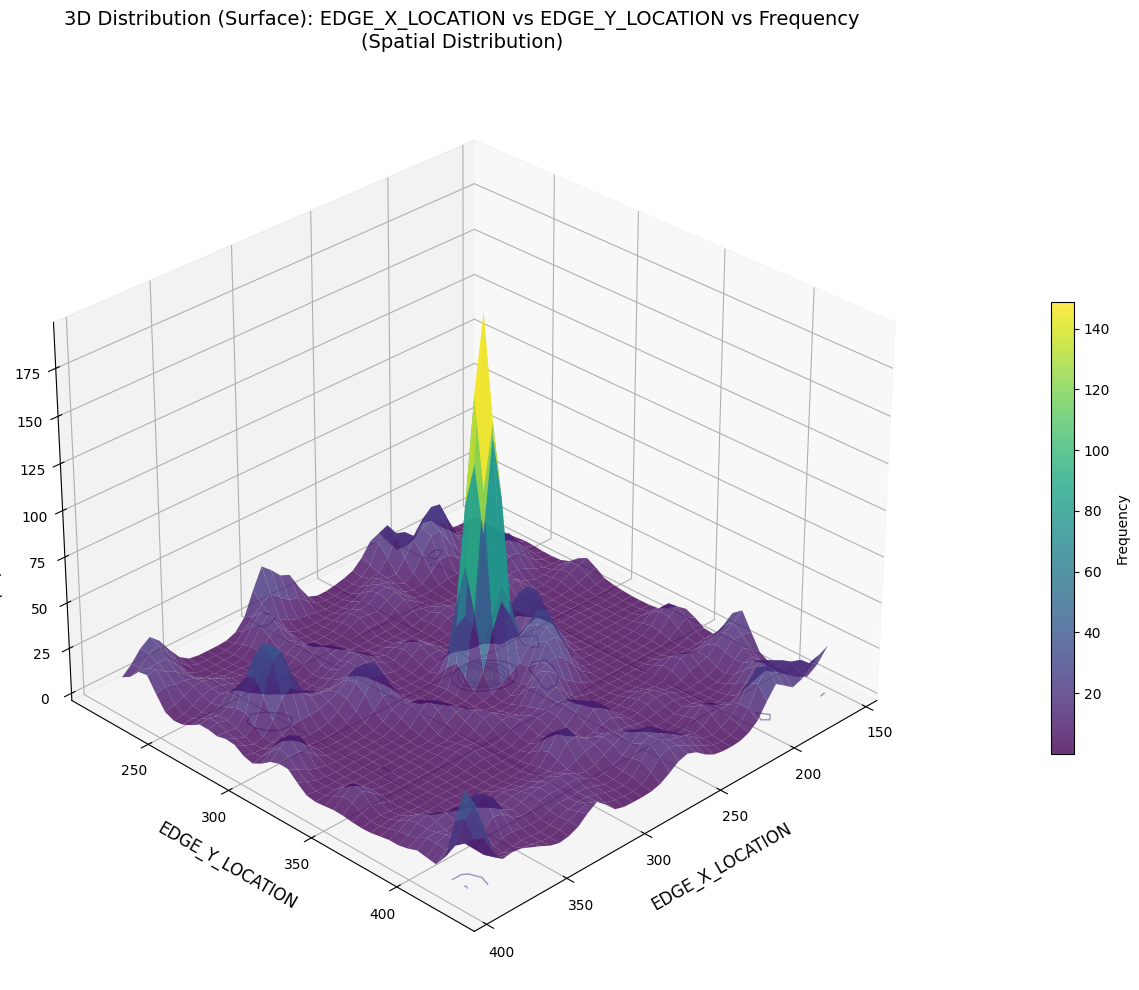


Statistics for EDGE_X_LOCATION vs EDGE_Y_LOCATION:
Total data points: 10719
EDGE_X_LOCATION range: [156.212, 393.639]
EDGE_Y_LOCATION range: [213.766, 431.380]
Max frequency in bin: 691.0
Bins with data: 528 / 1600


In [26]:
# Shows overall spatial distribution of cells
plot_3d_distribution('EDGE_X_LOCATION', 'EDGE_Y_LOCATION', merged, 
                     n_bins1=40, n_bins2=40, plot_type='surface',
                     title_suffix="\n(Spatial Distribution)")

In [27]:
# from utils import plot_interactive_3d_surface

# plot_interactive_3d_surface(merged)

In [28]:
# from utils import save_gif

# save_gif('cosine_vs_time_surface')

## Per-Track Mean-Velocity Cosine (Noise Removal)
- We group by the track ID and compute the average velocity components of the entire track, then take the dot product of that velocity to get the cosine of the average track velocity components and wave unit direction.
- This is an alternative to computing a cosine per instantaneous edge velocity and averaging the cosines, which is less accurate due to the noisiness of averaging cosines (more stochastic per row).
- Best interpreted as the *general track velocity direction with respect to the wave*.

Tracks with mean-velocity cosine < -0.7: 167


/var/folders/ry/vzt_t9_x03b06vnwjq6nlns00000gn/T/ipykernel_54943/1433777717.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


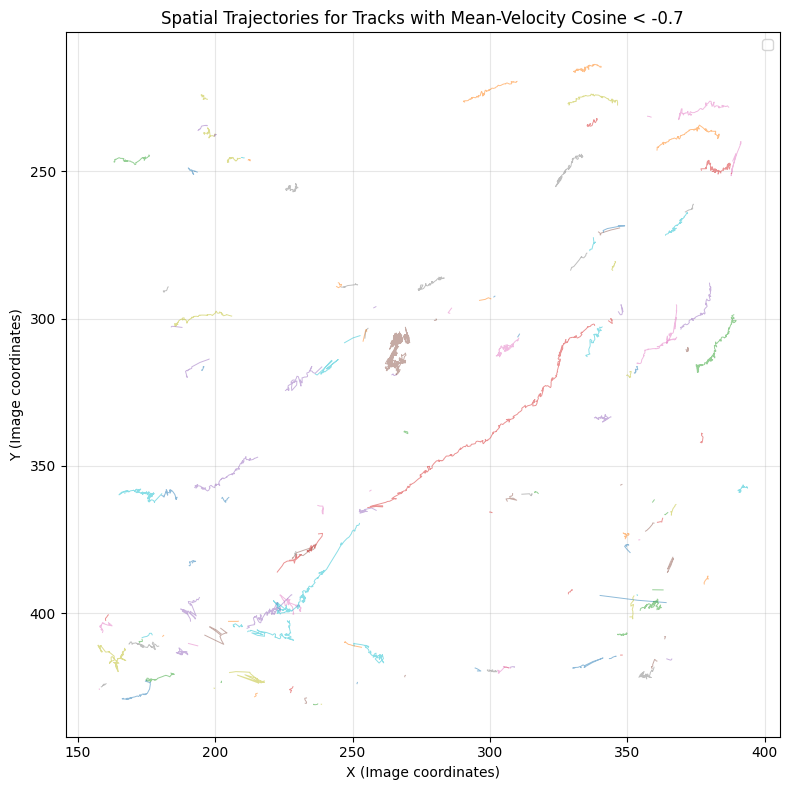

In [29]:
# Spatial plot of tracks whose *mean velocity vector* has cosine < 0.6 w.r.t. wave

# 1. Compute mean V_x, V_y per track
track_mean_vel = merged.groupby('TRACK_ID')[['V_x', 'V_y']].mean().copy()

# 2. Cosine of mean velocity vector with wave direction
# wave_x_unit, wave_y_unit are defined earlier in the notebook
track_mean_vel['speed_mean'] = np.sqrt(track_mean_vel['V_x']**2 + track_mean_vel['V_y']**2)
nonzero_mask = track_mean_vel['speed_mean'] > 0

# Initialize with NaNs to avoid divide-by-zero warnings
track_mean_vel['cos_mean_velocity'] = np.nan
track_mean_vel.loc[nonzero_mask, 'cos_mean_velocity'] = (
    track_mean_vel.loc[nonzero_mask, 'V_x'] * wave_x_unit +
    track_mean_vel.loc[nonzero_mask, 'V_y'] * wave_y_unit
) / track_mean_vel.loc[nonzero_mask, 'speed_mean']

# 3. Select tracks whose mean-velocity cosine is below threshold
threshold = -0.7
low_alignment_ids = track_mean_vel[track_mean_vel['cos_mean_velocity'] < threshold].index
print(f"Tracks with mean-velocity cosine < {threshold}: {len(low_alignment_ids)}")

# 4. Filter merged to only those tracks
low_alignment = merged[merged['TRACK_ID'].isin(low_alignment_ids)].copy()

# 5. Sort by track and time for cleaner trajectories
if 'EDGE_TIME' in low_alignment.columns:
    low_alignment = low_alignment.sort_values(['TRACK_ID', 'EDGE_TIME'])
else:
    low_alignment = low_alignment.sort_values(['TRACK_ID', 'POSITION_T_source'])

# 6. Spatial plot (image coordinates). Each track is one trajectory in x–y
plt.figure(figsize=(8, 8))

for tid, group in low_alignment.groupby('TRACK_ID'):
    plt.plot(
        group['EDGE_X_LOCATION'],
        group['EDGE_Y_LOCATION'],
        linewidth=0.7,
        alpha=0.5,
    )

# Optionally mark the final main centroid if defined
try:
    plt.scatter(centroid_x, centroid_y, c='red', s=80, marker='x', label='Final centroid')
except NameError:
    pass

plt.gca().invert_yaxis()  # keep ImageJ-style coordinates (origin at top-left)
plt.xlabel('X (Image coordinates)')
plt.ylabel('Y (Image coordinates)')
plt.title(f'Spatial Trajectories for Tracks with Mean-Velocity Cosine < {threshold}')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

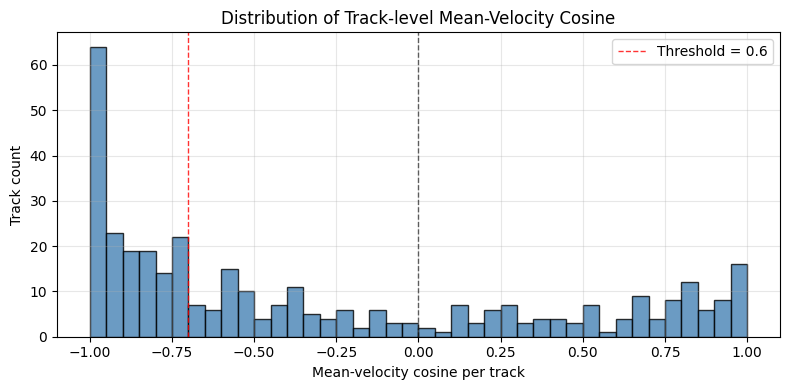

In [30]:
# Histogram of mean-velocity cosine per track
cos_vals_track = track_mean_vel['cos_mean_velocity'].dropna()

plt.figure(figsize=(8, 4))
plt.hist(cos_vals_track, bins=40, range=(-1, 1), color='steelblue', alpha=0.8, edgecolor='black')
plt.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.axvline(threshold, color='red', linestyle='--', linewidth=1, alpha=0.8, label='Threshold = 0.6')
plt.xlabel('Mean-velocity cosine per track')
plt.ylabel('Track count')
plt.title('Distribution of Track-level Mean-Velocity Cosine')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

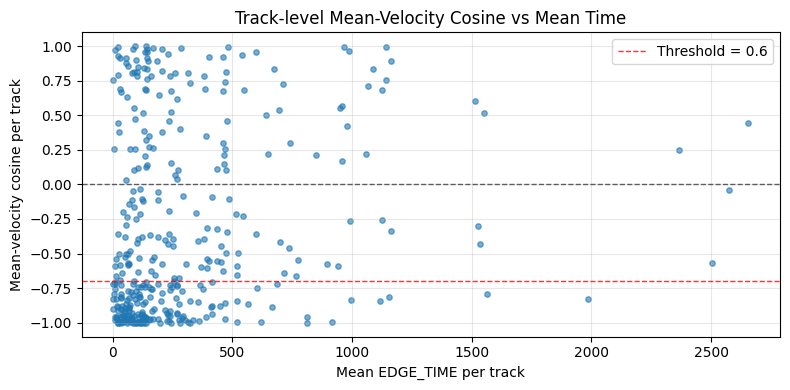

In [31]:
# Mean-velocity cosine vs mean EDGE_TIME per track
track_time_mean = merged.groupby('TRACK_ID')['EDGE_TIME'].mean()

common_ids = track_mean_vel.index.intersection(track_time_mean.index)
cos_track = track_mean_vel.loc[common_ids, 'cos_mean_velocity']
mean_time = track_time_mean.loc[common_ids]

plt.figure(figsize=(8, 4))
plt.scatter(mean_time, cos_track, s=15, alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.axhline(threshold, color='red', linestyle='--', linewidth=1, alpha=0.8, label='Threshold = 0.6')
plt.xlabel('Mean EDGE_TIME per track')
plt.ylabel('Mean-velocity cosine per track')
plt.title('Track-level Mean-Velocity Cosine vs Mean Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

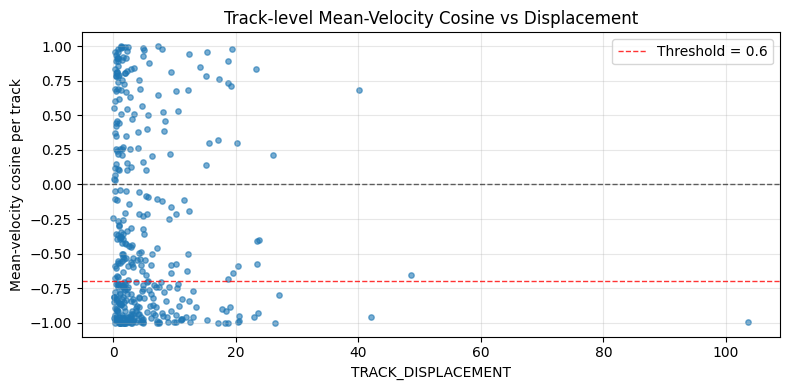

In [32]:
try:
    tracks_path = 'results/trial_3/20260206_224003_subset_tracks.csv'
    tracks = pd.read_csv(tracks_path, header=0, skiprows=[1, 2, 3])
    disp = tracks.set_index('TRACK_ID')['TRACK_DISPLACEMENT']

    common_ids_disp = track_mean_vel.index.intersection(disp.index)
    cos_track_disp = track_mean_vel.loc[common_ids_disp, 'cos_mean_velocity']
    displacement = disp.loc[common_ids_disp]

    plt.figure(figsize=(8, 4))
    plt.scatter(displacement, cos_track_disp, s=15, alpha=0.6)
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
    plt.axhline(threshold, color='red', linestyle='--', linewidth=1, alpha=0.8, label='Threshold = 0.6')
    plt.xlabel('TRACK_DISPLACEMENT')
    plt.ylabel('Mean-velocity cosine per track')
    plt.title('Track-level Mean-Velocity Cosine vs Displacement')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Could not load tracks displacement: {e}')

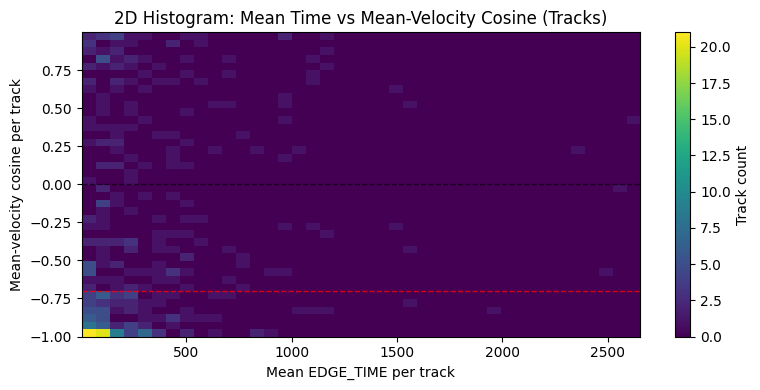

In [33]:
# 2D histogram: Mean-velocity cosine vs mean EDGE_TIME (density view)

cos_track = track_mean_vel['cos_mean_velocity'].dropna()
track_time_mean = merged.groupby('TRACK_ID')['EDGE_TIME'].mean().loc[cos_track.index]

# Define bins
n_time_bins = 40
n_cos_bins = 40

H_mv, time_edges_mv, cos_edges_mv = np.histogram2d(
    track_time_mean.values,
    cos_track.values,
    bins=[n_time_bins, n_cos_bins],
)

plt.figure(figsize=(8, 4))
plt.imshow(
    H_mv.T,
    aspect='auto',
    origin='lower',
    extent=[time_edges_mv[0], time_edges_mv[-1], cos_edges_mv[0], cos_edges_mv[-1]],
    cmap='viridis',
)
plt.colorbar(label='Track count')
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.axhline(threshold, color='red', linestyle='--', linewidth=1, alpha=0.8, label='Threshold = 0.6')
plt.xlabel('Mean EDGE_TIME per track')
plt.ylabel('Mean-velocity cosine per track')
plt.title('2D Histogram: Mean Time vs Mean-Velocity Cosine (Tracks)')
plt.tight_layout()
plt.show()

### Longest Track Analysis 
- Mean Per-Track Cosine vs Per-Edge Mean Cosine

In [34]:
tracks_path = 'results/trial_3/20260206_224003_subset_tracks.csv'
tracks = pd.read_csv(tracks_path, header=0, skiprows=[1, 2, 3])
longest_track_id = tracks.sort_values('TRACK_DISPLACEMENT', ascending=False).head()['TRACK_ID'].iloc[0]

In [35]:
longest_track = merged[merged['TRACK_ID'] == longest_track_id].sort_values('EDGE_TIME')
longest_V_x = (
    (longest_track['POSITION_X_target'].iloc[-1] - 
    longest_track['POSITION_X_source'].iloc[0]) / 
    np.ptp(longest_track['EDGE_TIME'])
)
longest_V_y = (
    (longest_track['POSITION_Y_target'].iloc[-1] - 
    longest_track['POSITION_Y_source'].iloc[0]) / 
    np.ptp(longest_track['EDGE_TIME'])
)

longest_V_magnitude = np.sqrt(longest_V_x**2 + longest_V_y**2)
longest_V_x_unit = longest_V_x / longest_V_magnitude
longest_V_y_unit = longest_V_y / longest_V_magnitude

# Dot product with wave unit vector
print(f'Longest track wave alignment: {longest_V_x_unit * wave_x_unit + longest_V_y_unit * wave_y_unit}')

Longest track wave alignment: -0.40874025318261986


In [36]:
longest_cos_mean_velocity = track_mean_vel.loc[longest_track_id]['cos_mean_velocity']
print(
    f'Longest track wave alignment (on average): {longest_cos_mean_velocity}'
)

Longest track wave alignment (on average): -0.9912823340877198


As expected, mean track velocity cosine more accurately depicts a track's average direction alignment with the wave.

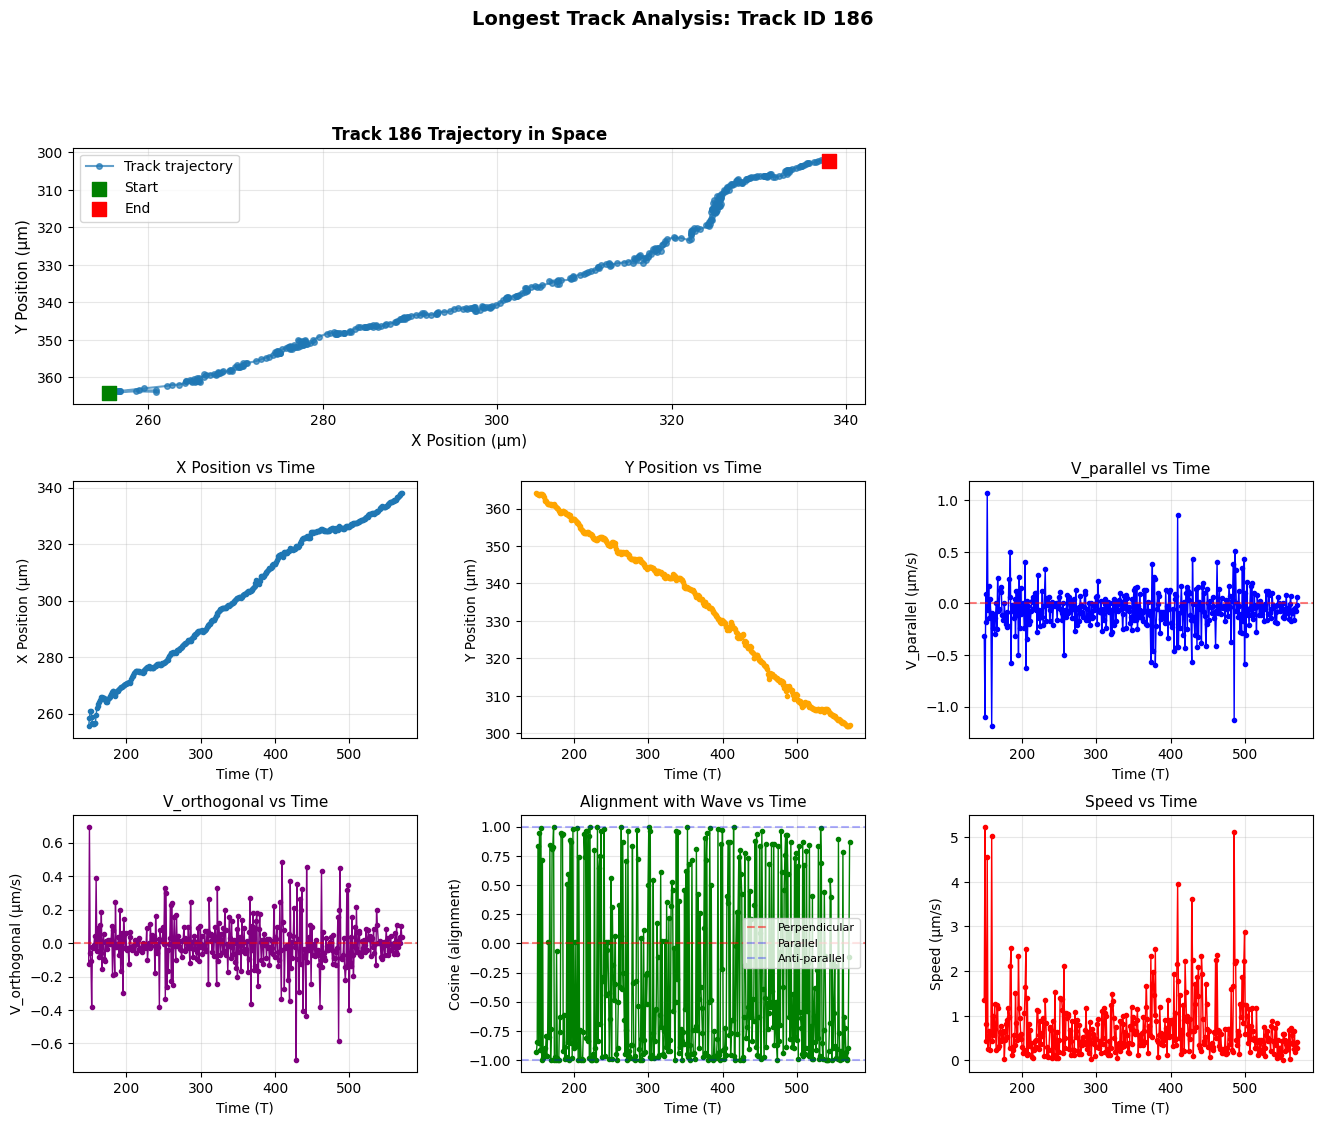

Track 186 Summary:
Edges: 419
Time range: 149.5 - 570.5
Displacement: 103.63 μm
Mean V_parallel: -0.061 μm/s
Mean V_orthogonal: -0.008 μm/s
Mean cosine: -0.319
Mean speed: 0.731 μm/s



In [37]:
# Visualize longest track - comprehensive view
longest_track = merged[merged['TRACK_ID'] == longest_track_id].copy().sort_values('EDGE_TIME' if 'EDGE_TIME' in merged.columns else 'POSITION_T_source')

# Get time axis
if 'EDGE_TIME' in longest_track.columns:
    T_track = longest_track['EDGE_TIME']
else:
    T_track = (longest_track['POSITION_T_source'] + longest_track['POSITION_T_target']) / 2

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Trajectory in X-Y space (top-left, spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(longest_track['EDGE_X_LOCATION'], longest_track['EDGE_Y_LOCATION'], 
         'o-', markersize=4, linewidth=1.5, alpha=0.7, label='Track trajectory')
ax1.scatter(longest_track['EDGE_X_LOCATION'].iloc[0], longest_track['EDGE_Y_LOCATION'].iloc[0],
           s=100, color='green', marker='s', label='Start', zorder=5)
ax1.scatter(longest_track['EDGE_X_LOCATION'].iloc[-1], longest_track['EDGE_Y_LOCATION'].iloc[-1],
           s=100, color='red', marker='s', label='End', zorder=5)
ax1.set_xlabel('X Position (μm)', fontsize=11)
ax1.set_ylabel('Y Position (μm)', fontsize=11)
ax1.set_title(f'Track {longest_track_id} Trajectory in Space', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.invert_yaxis()  # Image coordinates: Y increases downward

# 2. Position X vs Time (middle-left)
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(T_track, longest_track['EDGE_X_LOCATION'], 'o-', markersize=3, linewidth=1)
ax2.set_xlabel('Time (T)', fontsize=10)
ax2.set_ylabel('X Position (μm)', fontsize=10)
ax2.set_title('X Position vs Time', fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Position Y vs Time (middle-center)
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(T_track, longest_track['EDGE_Y_LOCATION'], 'o-', markersize=3, linewidth=1, color='orange')
ax3.set_xlabel('Time (T)', fontsize=10)
ax3.set_ylabel('Y Position (μm)', fontsize=10)
ax3.set_title('Y Position vs Time', fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. V_parallel vs Time (middle-right)
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(T_track, longest_track['V_parallel'], 'o-', markersize=3, linewidth=1, color='blue')
ax4.axhline(0, color='red', linestyle='--', alpha=0.5)
ax4.set_xlabel('Time (T)', fontsize=10)
ax4.set_ylabel('V_parallel (μm/s)', fontsize=10)
ax4.set_title('V_parallel vs Time', fontsize=11)
ax4.grid(True, alpha=0.3)

# 5. V_orthogonal vs Time (bottom-left)
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(T_track, longest_track['V_orthogonal'], 'o-', markersize=3, linewidth=1, color='purple')
ax5.axhline(0, color='red', linestyle='--', alpha=0.5)
ax5.set_xlabel('Time (T)', fontsize=10)
ax5.set_ylabel('V_orthogonal (μm/s)', fontsize=10)
ax5.set_title('V_orthogonal vs Time', fontsize=11)
ax5.grid(True, alpha=0.3)

# 6. Cosine (alignment) vs Time (bottom-center)
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(T_track, longest_track['cosine'], 'o-', markersize=3, linewidth=1, color='green')
ax6.axhline(0, color='red', linestyle='--', alpha=0.5, label='Perpendicular')
ax6.axhline(1, color='blue', linestyle='--', alpha=0.3, label='Parallel')
ax6.axhline(-1, color='blue', linestyle='--', alpha=0.3, label='Anti-parallel')
ax6.set_xlabel('Time (T)', fontsize=10)
ax6.set_ylabel('Cosine (alignment)', fontsize=10)
ax6.set_title('Alignment with Wave vs Time', fontsize=11)
ax6.set_ylim(-1.1, 1.1)
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# 7. Speed vs Time (bottom-right)
ax7 = fig.add_subplot(gs[2, 2])
ax7.plot(T_track, longest_track['SPEED'], 'o-', markersize=3, linewidth=1, color='red')
ax7.set_xlabel('Time (T)', fontsize=10)
ax7.set_ylabel('Speed (μm/s)', fontsize=10)
ax7.set_title('Speed vs Time', fontsize=11)
ax7.grid(True, alpha=0.3)

plt.suptitle(f'Longest Track Analysis: Track ID {longest_track_id}', fontsize=14, fontweight='bold', y=0.995)
plt.show()

# Add summary text
track_info = f"""Track {longest_track_id} Summary:
{'='*40}
Edges: {len(longest_track)}
Time range: {T_track.min():.1f} - {T_track.max():.1f}
Displacement: {tracks[tracks['TRACK_ID']==longest_track_id]['TRACK_DISPLACEMENT'].iloc[0]:.2f} μm
Mean V_parallel: {longest_track['V_parallel'].mean():.3f} μm/s
Mean V_orthogonal: {longest_track['V_orthogonal'].mean():.3f} μm/s
Mean cosine: {longest_track['cosine'].mean():.3f}
Mean speed: {longest_track['SPEED'].mean():.3f} μm/s
"""
print(track_info)

### 3D Unimodal Per Track Density Visualization

When plotting the density surface of the cosines of the mean track velocities, we get a more unimodal distribution, peaking at -1 instead of both -1 and +1. It most likely follows that the tracks moving exactly parallel in the direction of the wave (+1) could exhibit concentrated noise.

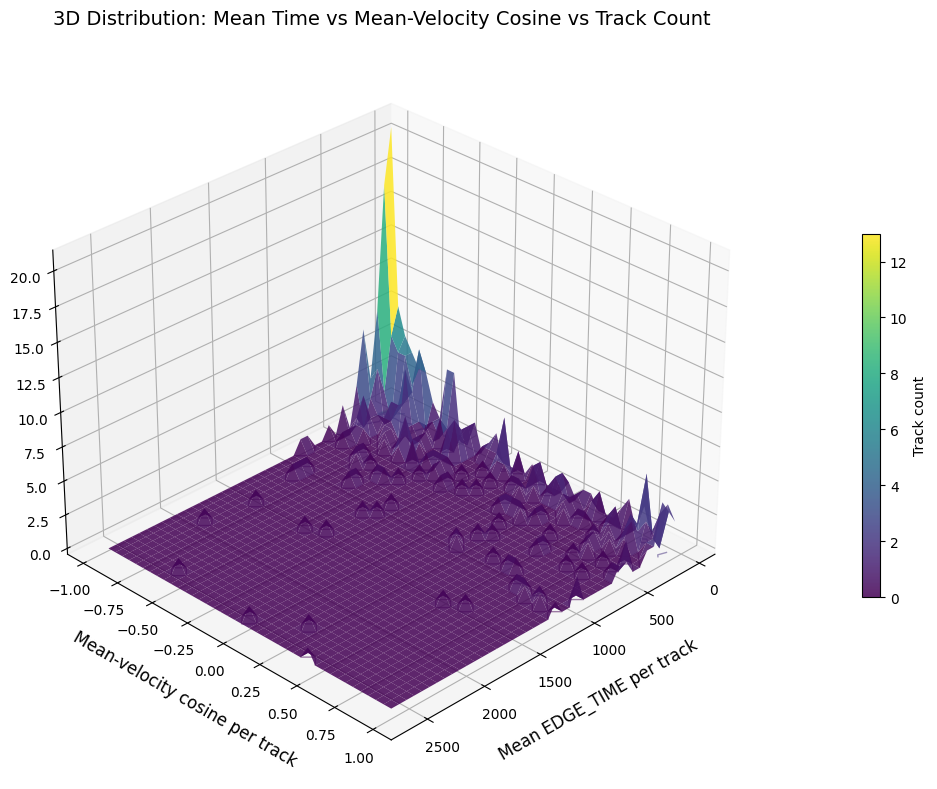

Track-level 3D distribution stats:
Tracks used: 371
Mean-velocity cosine range: [-1.000, 1.000]
Mean EDGE_TIME range: [2.5, 2655.5]
Max bin count: 21.0 (tracks)
Bins with data: 203 / 1600


In [38]:
from utils import plot_mean_velocity_cosine_3d

plot_mean_velocity_cosine_3d(track_mean_vel, merged)

# Velocities With Respect to Slug Centroid

This poses a greater challenge than the wave vector analysis, as the wave vector was **fixed**, rather than **dynamic**. In this case, the centroid direction is different for **every cell** and **every time** (the vector from centroid to cell changes), so:
- We must recompute $\hat{r}$ for each edge
- The geometry is radial (like gravity) rather than translational

In [39]:
# this is the (image) coordinate of the main final centroid in our ROI
centroid_x = 270
centroid_y = 309 

In [40]:
# get actual computed center point (last remaining track)
centroid_x, centroid_y = (
    np.array(
        merged.sort_values(by='EDGE_TIME', ascending=False)
            [['POSITION_X_target', 'POSITION_Y_target']]
            .iloc[0]
    )
)
print(centroid_x, centroid_y)

270.0846984126984 307.06584126984126


### 1. Compute distance vector
We compute the radial vector (of cell positions w.r.t. the centroid) for each cell at every time.

In [41]:
merged['dx_centroid'] = merged['EDGE_X_LOCATION'] - centroid_x
merged['dy_centroid'] = merged['EDGE_Y_LOCATION'] - centroid_y
merged['dy_centroid'] = merged['dy_centroid'] * -1 # convert to math coords

# Radial distance from centroid
merged['r_centroid'] = np.sqrt(merged['dx_centroid']**2 + merged['dy_centroid']**2)

In [42]:
merged.head()

LABEL  TRACK_ID  SPOT_SOURCE_ID  SPOT_TARGET_ID  LINK_COST  \
0  ID554826 → ID554635         0          554826          554635  10.479494   
1  ID555081 → ID554981         0          555081          554981  28.002000   
2  ID554981 → ID554772         0          554981          554772   0.042748   
3  ID556111 → ID556342         0          556111          556342   2.338630   
4  ID554635 → ID555081         0          554635          555081   9.016805   

   DIRECTIONAL_CHANGE_RATE     SPEED  DISPLACEMENT  EDGE_TIME  \
0                      NaN  2.472511      2.472511        0.5   
1                 0.622373  1.774840      1.774840        2.5   
2                 2.447633  1.060959      1.060959        3.5   
3                 2.840419  0.952779      0.952779        8.5   
4                 2.855178  0.461510      0.461510        1.5   

   EDGE_X_LOCATION  ...       V_x       V_y  VELOCITY    cosine  V_parallel  \
0       190.847919  ... -0.353514  0.503299  2.472511  0.106048    0.065225   
1       191.006070  ...  0.358682 -0.257426  1.774840 -0.428075   -0.188995   
2       191.593560  ... -0.066401  0.255428  1.060959 -0.249252   -0.065782   
3       191.788058  ...  0.183124 -0.150460  0.952779 -0.368176   -0.087261   
4       190.211231  ...  0.036757 -0.108759  0.461510  0.179314    0.020586   

   V_orthogonal  time_bin  dx_centroid  dy_centroid  r_centroid  
0     -0.611841         0   -79.236780    57.366820   97.823409  
1      0.399209         0   -79.078628    57.423814   97.728828  
2     -0.255704         0   -78.491138    57.419797   97.251693  
3      0.220468         0   -78.296641    56.672362   96.654646  
4      0.112991         0   -79.873467    58.159853   98.804551  

[5 rows x 29 columns]

### 2. Convert raw distance to unit vector

In [43]:
# Avoid division by zero
eps = 1e-9
merged['r_safe'] = merged['r_centroid'].clip(lower=eps)

# Radial unit components
merged['r_hat_x'] = merged['dx_centroid'] / merged['r_safe']
merged['r_hat_y'] = merged['dy_centroid'] / merged['r_safe']

# Tangential unit vector: rotate radial by +90° in ImageJ coords
# (x, y) -> (-y, x) gives a perpendicular vector
merged['t_hat_x'] = -merged['r_hat_y']
merged['t_hat_y'] =  merged['r_hat_x']

In [44]:
merged.head()

LABEL  TRACK_ID  SPOT_SOURCE_ID  SPOT_TARGET_ID  LINK_COST  \
0  ID554826 → ID554635         0          554826          554635  10.479494   
1  ID555081 → ID554981         0          555081          554981  28.002000   
2  ID554981 → ID554772         0          554981          554772   0.042748   
3  ID556111 → ID556342         0          556111          556342   2.338630   
4  ID554635 → ID555081         0          554635          555081   9.016805   

   DIRECTIONAL_CHANGE_RATE     SPEED  DISPLACEMENT  EDGE_TIME  \
0                      NaN  2.472511      2.472511        0.5   
1                 0.622373  1.774840      1.774840        2.5   
2                 2.447633  1.060959      1.060959        3.5   
3                 2.840419  0.952779      0.952779        8.5   
4                 2.855178  0.461510      0.461510        1.5   

   EDGE_X_LOCATION  ...  V_orthogonal  time_bin  dx_centroid  dy_centroid  \
0       190.847919  ...     -0.611841         0   -79.236780    57.366820   
1       191.006070  ...      0.399209         0   -79.078628    57.423814   
2       191.593560  ...     -0.255704         0   -78.491138    57.419797   
3       191.788058  ...      0.220468         0   -78.296641    56.672362   
4       190.211231  ...      0.112991         0   -79.873467    58.159853   

   r_centroid     r_safe   r_hat_x   r_hat_y   t_hat_x   t_hat_y  
0   97.823409  97.823409 -0.809998  0.586432 -0.586432 -0.809998  
1   97.728828  97.728828 -0.809164  0.587583 -0.587583 -0.809164  
2   97.251693  97.251693 -0.807093  0.590425 -0.590425 -0.807093  
3   96.654646  96.654646 -0.810066  0.586339 -0.586339 -0.810066  
4   98.804551  98.804551 -0.808399  0.588635 -0.588635 -0.808399  

[5 rows x 34 columns]

### 3. Project Radial and Tangential Velocities

In [45]:
# Radial velocity: component of v along r_hat
merged['v_radial'] = (
    merged['V_x'] * merged['r_hat_x'] +
    merged['V_y'] * merged['r_hat_y']
)

# Tangential velocity: component of v along t_hat
merged['v_tangential'] = (
    merged['V_x'] * merged['t_hat_x'] +
    merged['V_y'] * merged['t_hat_y']
)

## EDA

### Radial Distance and Velocity Analysis

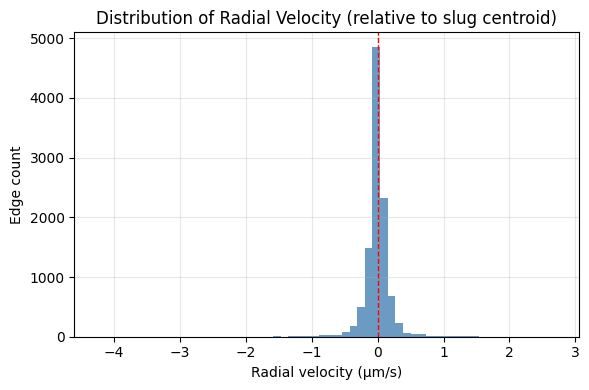

In [46]:
plt.figure(figsize=(6, 4))
plt.hist(merged['v_radial'], bins=60, color='steelblue', alpha=0.8)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Radial velocity (μm/s)')
plt.ylabel('Edge count')
plt.title('Distribution of Radial Velocity (relative to slug centroid)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

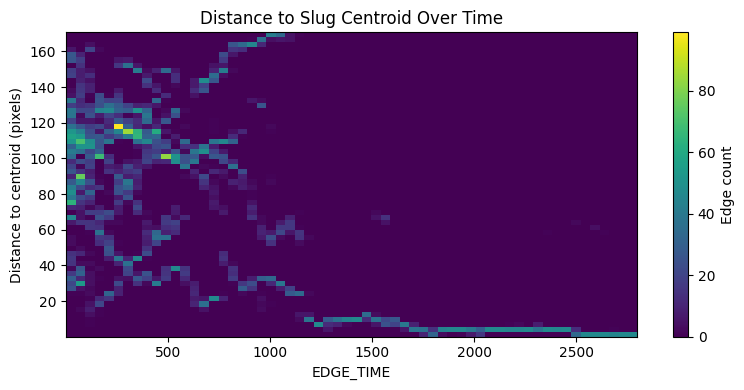

In [47]:
time_vals = merged['EDGE_TIME']
dist_vals = merged['r_centroid']

H, t_edges, r_edges = np.histogram2d(
    time_vals, dist_vals,
    bins=[60, 60]
)

plt.figure(figsize=(8, 4))
plt.imshow(
    H.T,
    aspect='auto',
    origin='lower',
    extent=[t_edges[0], t_edges[-1], r_edges[0], r_edges[-1]],
    cmap='viridis'
)
plt.colorbar(label='Edge count')
plt.xlabel('EDGE_TIME')
plt.ylabel('Distance to centroid (pixels)')
plt.title('Distance to Slug Centroid Over Time')
plt.tight_layout()
plt.show()

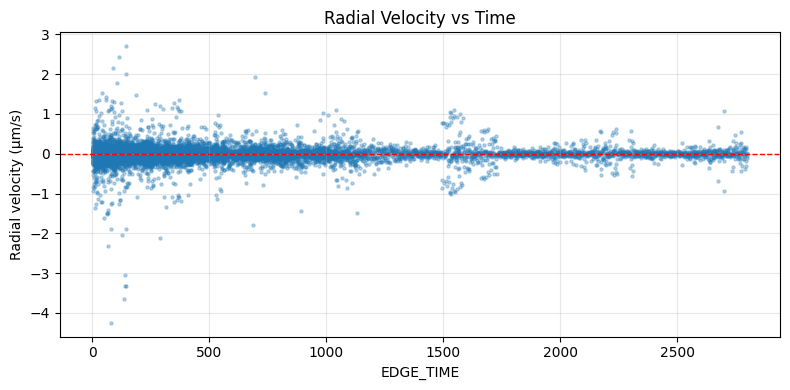

In [48]:
plt.figure(figsize=(8, 4))
plt.scatter(time_vals, merged['v_radial'], s=5, alpha=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('EDGE_TIME')
plt.ylabel('Radial velocity (μm/s)')
plt.title('Radial Velocity vs Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
track_stats = merged.groupby('TRACK_ID').agg({
    'v_radial': 'mean',
    'r_centroid': ['first', 'last', 'mean']
})

track_stats.columns = ['v_radial_mean', 'r_initial', 'r_final', 'r_mean']
track_stats = track_stats.reset_index()

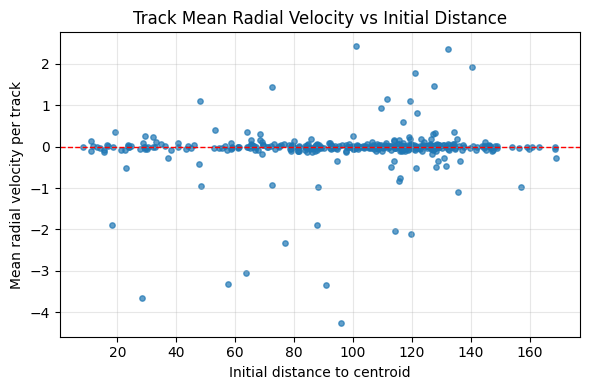

In [50]:
plt.figure(figsize=(6, 4))
plt.scatter(track_stats['r_initial'], track_stats['v_radial_mean'], s=15, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Initial distance to centroid')
plt.ylabel('Mean radial velocity per track')
plt.title('Track Mean Radial Velocity vs Initial Distance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Radial Cosine Analysis

In [51]:
velocity_magnitude = np.sqrt(V_x**2 + V_y**2)

# Unit velocity components
merged['V_hat_x'] = merged['V_x'] / velocity_magnitude
merged['V_hat_y'] = merged['V_y'] / velocity_magnitude

# Radial cosine: alignment of velocity with radial direction from centroid
merged['radial_cosine'] = (
    merged['V_hat_x'] * merged['r_hat_x'] +
    merged['V_hat_y'] * merged['r_hat_y']
)

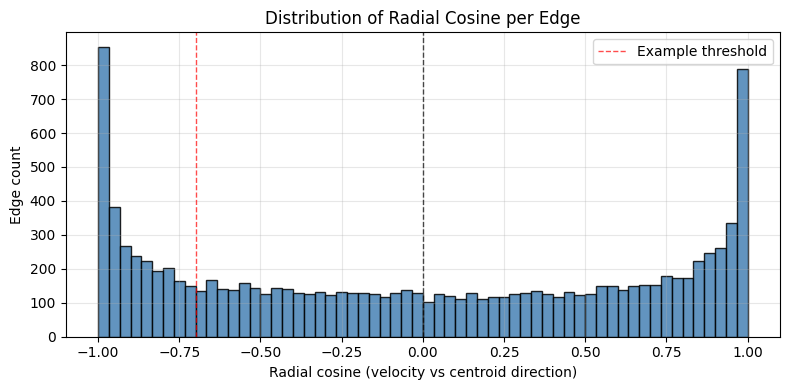

In [52]:
plt.figure(figsize=(8, 4))
plt.hist(merged['radial_cosine'].dropna(), bins=60, range=(-1, 1),
         color='steelblue', alpha=0.85, edgecolor='black')
plt.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(-0.7, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Example threshold')
plt.xlabel('Radial cosine (velocity vs centroid direction)')
plt.ylabel('Edge count')
plt.title('Distribution of Radial Cosine per Edge')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

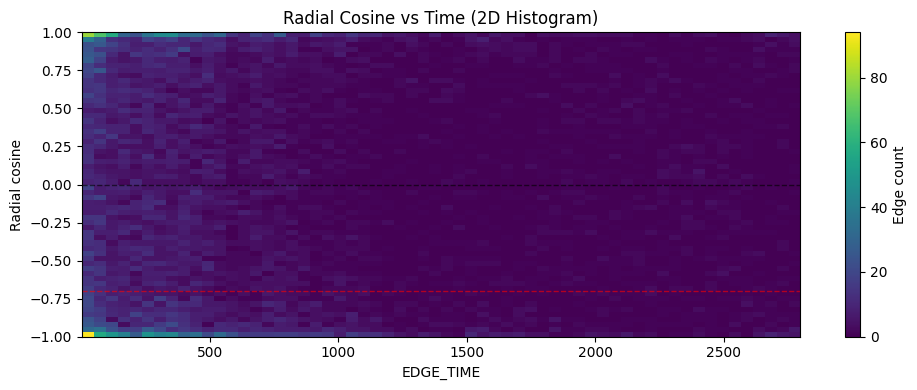

In [53]:
time_vals = merged['EDGE_TIME'].values
cos_vals  = merged['radial_cosine'].values

n_time_bins = 60
n_cos_bins  = 60

time_bins = np.linspace(time_vals.min(), time_vals.max(), n_time_bins + 1)
cos_bins  = np.linspace(-1, 1, n_cos_bins + 1)

H, t_edges, c_edges = np.histogram2d(time_vals, cos_vals, bins=[time_bins, cos_bins])

plt.figure(figsize=(10, 4))
plt.imshow(
    H.T,
    aspect='auto',
    origin='lower',
    extent=[t_edges[0], t_edges[-1], c_edges[0], c_edges[-1]],
    cmap='viridis'
)
plt.colorbar(label='Edge count')
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.axhline(-0.7, color='red', linestyle='--', linewidth=1, alpha=0.6)
plt.xlabel('EDGE_TIME')
plt.ylabel('Radial cosine')
plt.title('Radial Cosine vs Time (2D Histogram)')
plt.tight_layout()
plt.show()

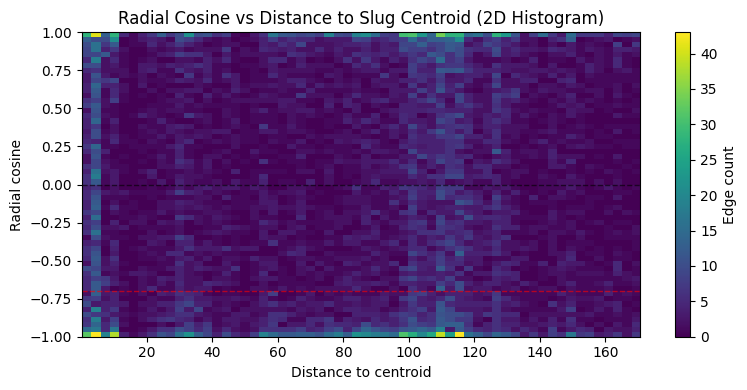

In [54]:
dist_vals = merged['r_centroid'].values
cos_vals  = merged['radial_cosine'].values

n_dist_bins = 60
n_cos_bins  = 60

dist_bins = np.linspace(dist_vals.min(), dist_vals.max(), n_dist_bins + 1)
cos_bins  = np.linspace(-1, 1, n_cos_bins + 1)

H_dc, d_edges, c_edges = np.histogram2d(dist_vals, cos_vals, bins=[dist_bins, cos_bins])

plt.figure(figsize=(8, 4))
plt.imshow(
    H_dc.T,
    aspect='auto',
    origin='lower',
    extent=[d_edges[0], d_edges[-1], c_edges[0], c_edges[-1]],
    cmap='viridis'
)
plt.colorbar(label='Edge count')
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.axhline(-0.7, color='red', linestyle='--', linewidth=1, alpha=0.6)
plt.xlabel('Distance to centroid')
plt.ylabel('Radial cosine')
plt.title('Radial Cosine vs Distance to Slug Centroid (2D Histogram)')
plt.tight_layout()
plt.show()

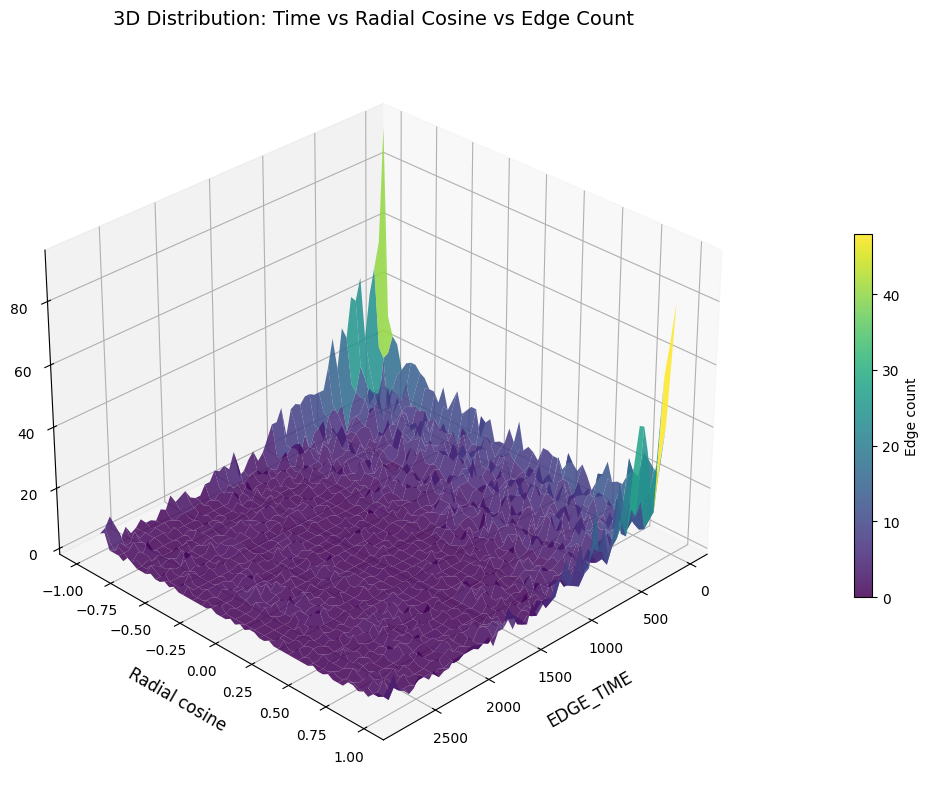

In [55]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Reuse H, t_edges, c_edges from the time vs cosine 2D histogram above
T_centers = (t_edges[:-1] + t_edges[1:]) / 2
C_centers = (c_edges[:-1] + c_edges[1:]) / 2
T_mesh, C_mesh = np.meshgrid(T_centers, C_centers, indexing='ij')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    T_mesh, C_mesh, H,
    cmap='viridis',
    alpha=0.85,
    linewidth=0,
    antialiased=True
)

ax.set_xlabel('EDGE_TIME', fontsize=12, labelpad=10)
ax.set_ylabel('Radial cosine', fontsize=12, labelpad=10)
ax.set_zlabel('Edge count', fontsize=12, labelpad=10)
ax.set_title('3D Distribution: Time vs Radial Cosine vs Edge Count', fontsize=14, pad=20)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, pad=0.1, label='Edge count')
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

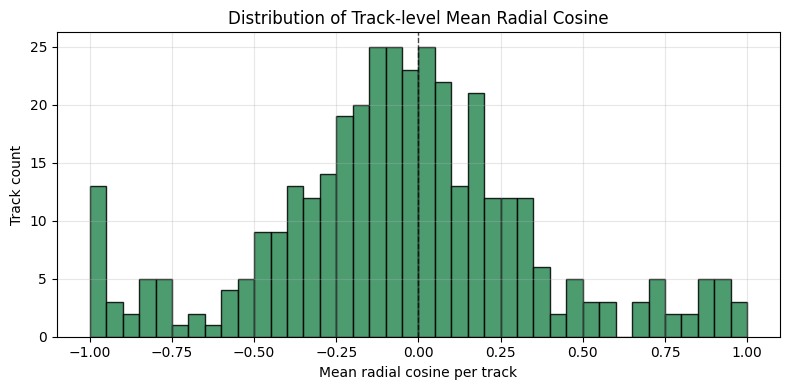

In [56]:
track_radial_cos = merged.groupby('TRACK_ID')['radial_cosine'].mean().dropna()

plt.figure(figsize=(8, 4))
plt.hist(track_radial_cos, bins=40, range=(-1, 1),
         color='seagreen', alpha=0.85, edgecolor='black')
plt.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.xlabel('Mean radial cosine per track')
plt.ylabel('Track count')
plt.title('Distribution of Track-level Mean Radial Cosine')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Radial Acceleration w.r.t Centroids

In [57]:
merged_sorted = merged.sort_values(['TRACK_ID', 'EDGE_TIME']).copy()
merged_sorted.head()

LABEL  TRACK_ID  SPOT_SOURCE_ID  SPOT_TARGET_ID  LINK_COST  \
0   ID554826 → ID554635         0          554826          554635  10.479494   
4   ID554635 → ID555081         0          554635          555081   9.016805   
1   ID555081 → ID554981         0          555081          554981  28.002000   
2   ID554981 → ID554772         0          554981          554772   0.042748   
10  ID554772 → ID555274         0          554772          555274   3.486766   

    DIRECTIONAL_CHANGE_RATE     SPEED  DISPLACEMENT  EDGE_TIME  \
0                       NaN  2.472511      2.472511        0.5   
4                  2.855178  0.461510      0.461510        1.5   
1                  0.622373  1.774840      1.774840        2.5   
2                  2.447633  1.060959      1.060959        3.5   
10                 2.920901  1.014701      1.014701        4.5   

    EDGE_X_LOCATION  ...     r_safe   r_hat_x   r_hat_y   t_hat_x   t_hat_y  \
0        190.847919  ...  97.823409 -0.809998  0.586432 -0.586432 -0.809998   
4        190.211231  ...  98.804551 -0.808399  0.588635 -0.588635 -0.808399   
1        191.006070  ...  97.728828 -0.809164  0.587583 -0.587583 -0.809164   
2        191.593560  ...  97.251693 -0.807093  0.590425 -0.590425 -0.807093   
10       191.477157  ...  97.349413 -0.807478  0.589897 -0.589897 -0.807478   

    v_radial  v_tangential   V_hat_x   V_hat_y  radial_cosine  
0   0.581497     -0.200359 -0.574776  0.818311       0.945452  
4  -0.093734      0.066284  0.320177 -0.947358      -0.816479  
1  -0.441492     -0.002455  0.812419 -0.583074      -0.999985  
2   0.204403     -0.166950 -0.251596  0.967832       0.774493  
10 -0.155667      0.198694  0.033631 -0.999434      -0.616720  

[5 rows x 39 columns]

### 1. Compute Radial Velocity and Time Differences at $i$ and $i-1$

In [58]:
# Group by track and compute differences

# at row i, give v_radial from row i-1
merged_sorted['v_radial_prev'] = merged_sorted.groupby('TRACK_ID')['v_radial'].shift(1) 

# get difference of edge time with i and i-1th row
merged_sorted['delta_t'] = merged_sorted.groupby('TRACK_ID')['EDGE_TIME'].diff()

# Radial acceleration = change in radial velocity / change in time
# Avoid division by zero
eps = 1e-9
delta_t_safe = merged_sorted['delta_t'].clip(lower=eps)

merged_sorted['a_radial'] = (
    (merged_sorted['v_radial'] - merged_sorted['v_radial_prev']) / delta_t_safe
)

In [59]:
# These should be True for all rows
nan_mask = merged_sorted['delta_t'].isna()
print(f"Rows where delta_t is NaN: {nan_mask.sum()}")

# Check if v_radial_prev is also NaN at those same rows
print(f"v_radial_prev NaN at same rows: {merged_sorted.loc[nan_mask, 'v_radial_prev'].isna().sum()}")

# Should also verify these are the first edge of each track
first_edges = merged_sorted.groupby('TRACK_ID').head(1)
print(f"Number of tracks: {merged_sorted['TRACK_ID'].nunique()}")
print(f"First edges have delta_t NaN: {(first_edges['delta_t'].isna()).sum()}")

Rows where delta_t is NaN: 371
v_radial_prev NaN at same rows: 371
Number of tracks: 371
First edges have delta_t NaN: 371


In [60]:
# Set first edge of each track to NaN (no previous edge to compare)
merged_sorted.loc[merged_sorted['delta_t'].isna(), 'a_radial'] = np.nan

### 2. Remove Outliers / Jumps

In [61]:
# Remove top N outliers by absolute acceleration
N = 1  # adjust as needed
outlier_indices = merged_sorted['a_radial'].abs().nlargest(N).index

print(f"Removing {len(outlier_indices)} outliers:")
print(merged_sorted.loc[outlier_indices, ['TRACK_ID', 'EDGE_TIME', 'a_radial', 'r_centroid']])

merged_sorted = merged_sorted.drop(index=outlier_indices).copy()

Removing 1 outliers:
      TRACK_ID  EDGE_TIME      a_radial  r_centroid
1728        59       66.5  3.335101e+07  128.124166


## EDA

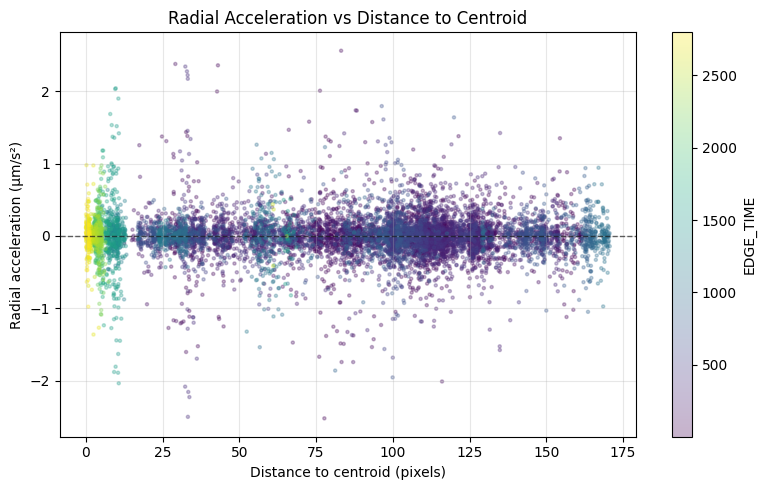

In [62]:
plt.figure(figsize=(8, 5))
plt.scatter(
    merged_sorted['r_centroid'],
    merged_sorted['a_radial'],
    s=5,
    alpha=0.3,
    c=merged_sorted['EDGE_TIME'],
    cmap='viridis'
)
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.xlabel('Distance to centroid (pixels)')
plt.ylabel('Radial acceleration (μm/s²)')
plt.colorbar(label='EDGE_TIME')
plt.title('Radial Acceleration vs Distance to Centroid')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

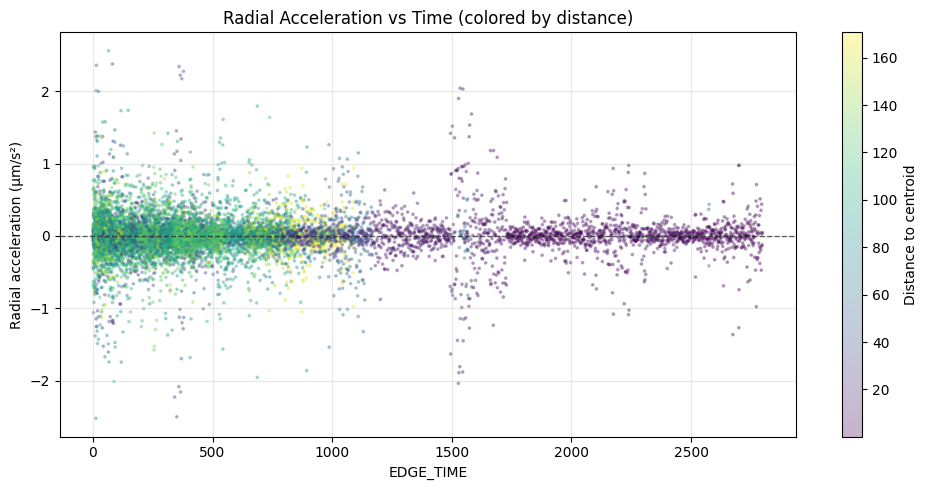

In [63]:
plt.figure(figsize=(10, 5))
plt.scatter(merged_sorted['EDGE_TIME'], merged_sorted['a_radial'], 
            s=3, alpha=0.3, c=merged_sorted['r_centroid'], cmap='viridis')
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.xlabel('EDGE_TIME')
plt.ylabel('Radial acceleration (μm/s²)')
plt.colorbar(label='Distance to centroid')
plt.title('Radial Acceleration vs Time (colored by distance)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

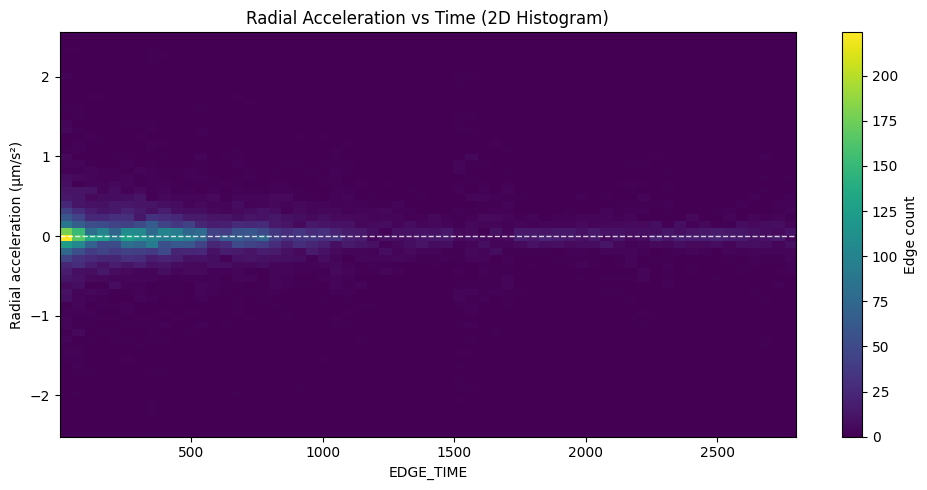

In [64]:
time_vals = merged_sorted['EDGE_TIME'].values
acc_vals = merged_sorted['a_radial'].dropna().values
time_vals_acc = merged_sorted.loc[merged_sorted['a_radial'].notna(), 'EDGE_TIME'].values

n_time_bins = 60
n_acc_bins = 60

time_bins = np.linspace(time_vals_acc.min(), time_vals_acc.max(), n_time_bins + 1)
acc_bins = np.linspace(acc_vals.min(), acc_vals.max(), n_acc_bins + 1)

H, t_edges, a_edges = np.histogram2d(time_vals_acc, acc_vals, bins=[time_bins, acc_bins])

plt.figure(figsize=(10, 5))
plt.imshow(
    H.T,
    aspect='auto',
    origin='lower',
    extent=[t_edges[0], t_edges[-1], a_edges[0], a_edges[-1]],
    cmap='viridis'
)
plt.colorbar(label='Edge count')
plt.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.8)
plt.xlabel('EDGE_TIME')
plt.ylabel('Radial acceleration (μm/s²)')
plt.title('Radial Acceleration vs Time (2D Histogram)')
plt.tight_layout()
plt.show()

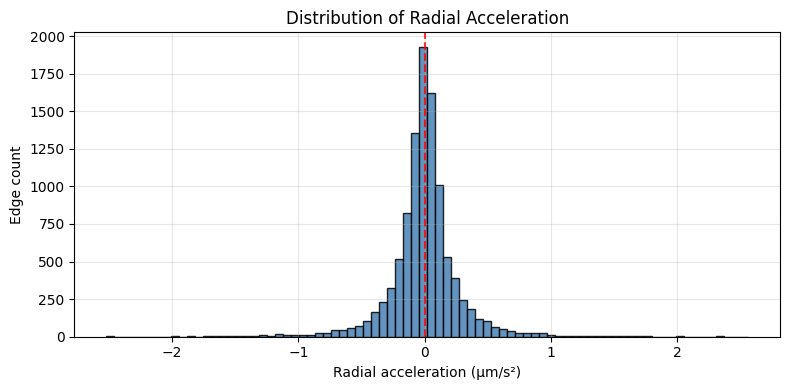

In [65]:
plt.figure(figsize=(8, 4))
plt.hist(merged_sorted['a_radial'].dropna(), bins=80, 
         color='steelblue', alpha=0.85, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.xlabel('Radial acceleration (μm/s²)')
plt.ylabel('Edge count')
plt.title('Distribution of Radial Acceleration')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

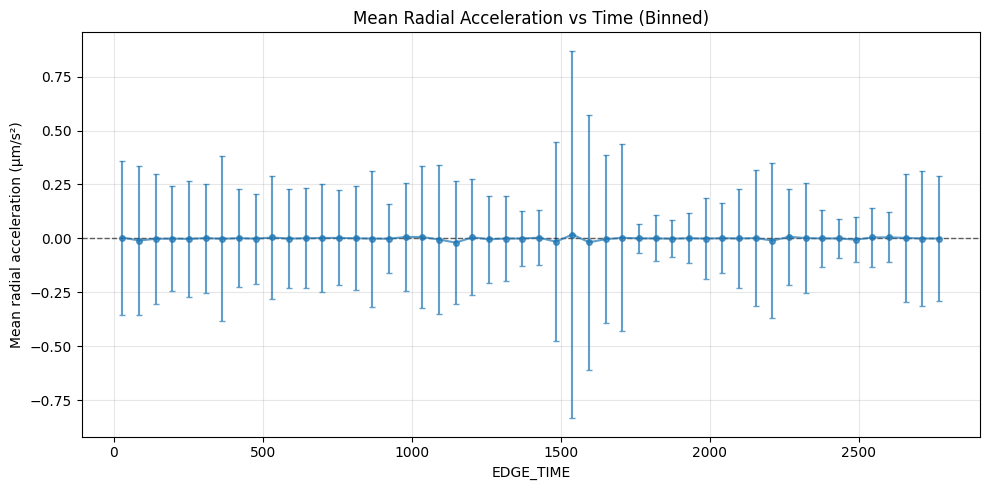

In [66]:
# Bin time and compute mean acceleration per bin
n_time_bins = 50
time_bins = np.linspace(merged_sorted['EDGE_TIME'].min(), 
                        merged_sorted['EDGE_TIME'].max(), 
                        n_time_bins + 1)
merged_sorted['time_bin'] = pd.cut(merged_sorted['EDGE_TIME'], bins=time_bins)

acc_by_time = merged_sorted.groupby('time_bin')['a_radial'].agg(['mean', 'std', 'count']).reset_index()
acc_by_time['time_center'] = acc_by_time['time_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(10, 5))
plt.errorbar(
    acc_by_time['time_center'],
    acc_by_time['mean'],
    yerr=acc_by_time['std'],
    fmt='o-',
    capsize=2,
    alpha=0.7,
    markersize=4
)
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.xlabel('EDGE_TIME')
plt.ylabel('Mean radial acceleration (μm/s²)')
plt.title('Mean Radial Acceleration vs Time (Binned)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

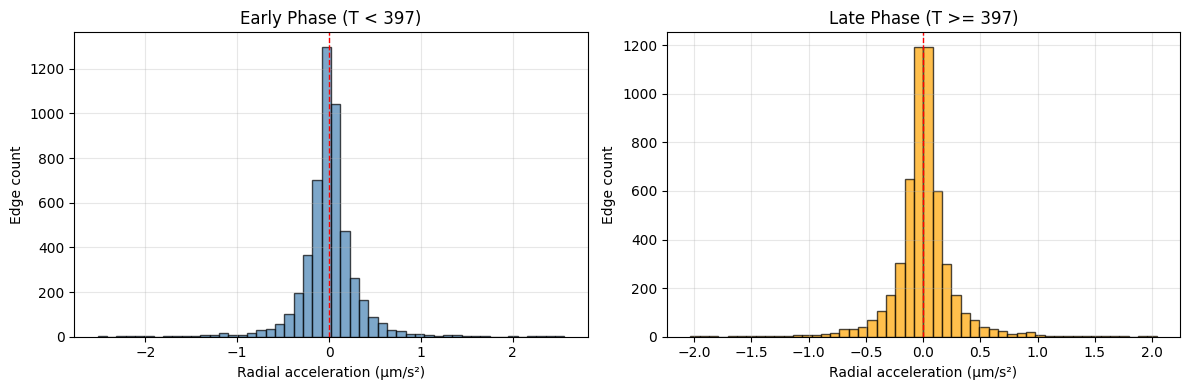

Early phase: mean = -0.0014, std = 0.3167
Late phase:  mean = 0.0007, std = 0.2717


In [67]:
# Split into early and late phases
time_median = merged_sorted['EDGE_TIME'].median()
early = merged_sorted[merged_sorted['EDGE_TIME'] < time_median]['a_radial'].dropna()
late = merged_sorted[merged_sorted['EDGE_TIME'] >= time_median]['a_radial'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(early, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Radial acceleration (μm/s²)')
axes[0].set_ylabel('Edge count')
axes[0].set_title(f'Early Phase (T < {time_median:.0f})')
axes[0].grid(True, alpha=0.3)

axes[1].hist(late, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Radial acceleration (μm/s²)')
axes[1].set_ylabel('Edge count')
axes[1].set_title(f'Late Phase (T >= {time_median:.0f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Early phase: mean = {early.mean():.4f}, std = {early.std():.4f}")
print(f"Late phase:  mean = {late.mean():.4f}, std = {late.std():.4f}")

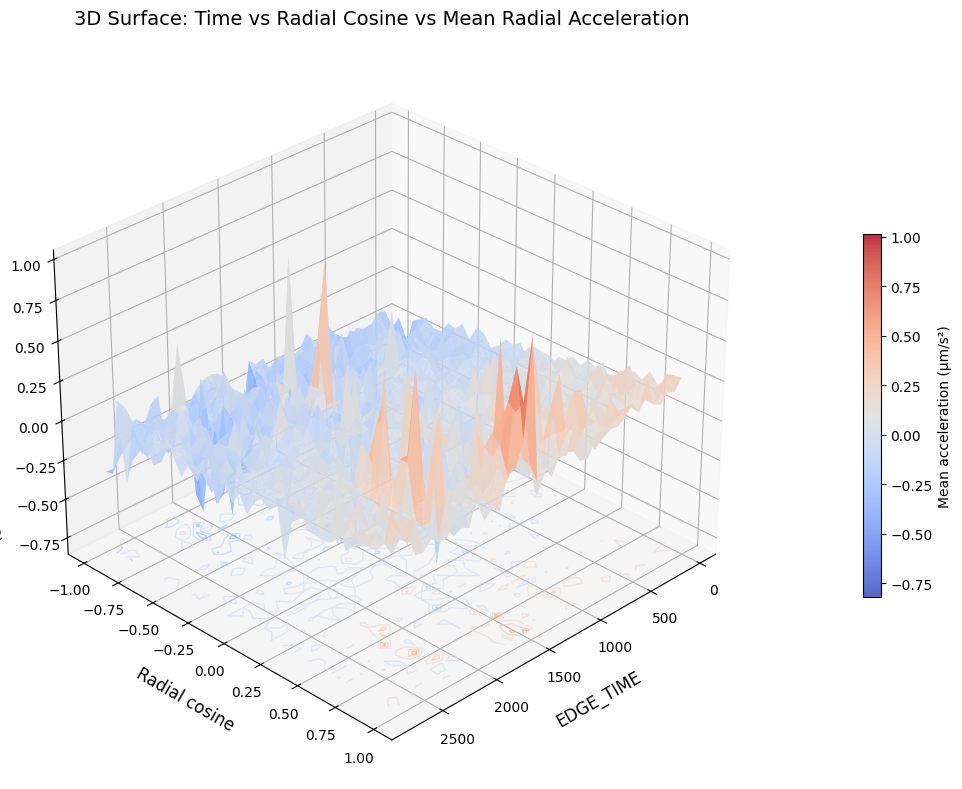

In [68]:
# Filter out NaN accelerations and radial cosine
acc_cos_data = merged_sorted[
    merged_sorted['a_radial'].notna() & 
    merged_sorted['radial_cosine'].notna()
].copy()

time_vals = acc_cos_data['EDGE_TIME'].values
cos_vals = acc_cos_data['radial_cosine'].values
acc_vals = acc_cos_data['a_radial'].values

# Create bins
n_time_bins = 40
n_cos_bins = 40

time_bins = np.linspace(time_vals.min(), time_vals.max(), n_time_bins + 1)
cos_bins = np.linspace(-1, 1, n_cos_bins + 1)

# 2D histogram: time vs radial cosine
H, t_edges, c_edges = np.histogram2d(time_vals, cos_vals, bins=[time_bins, cos_bins])

# Mean acceleration per bin
H_acc, _, _ = np.histogram2d(time_vals, cos_vals, bins=[time_bins, cos_bins], weights=acc_vals)
H_acc_mean = np.divide(H_acc, H, out=np.zeros_like(H_acc), where=H > 0)

# Bin centers
t_centers = (t_edges[:-1] + t_edges[1:]) / 2
c_centers = (c_edges[:-1] + c_edges[1:]) / 2
T_mesh, C_mesh = np.meshgrid(t_centers, c_centers, indexing='ij')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    T_mesh, C_mesh, H_acc_mean,
    cmap='coolwarm',
    alpha=0.85,
    linewidth=0,
    antialiased=True,
    vmin=H_acc_mean[H > 0].min() if np.any(H > 0) else 0,
    vmax=H_acc_mean[H > 0].max() if np.any(H > 0) else 0,
)

ax.contour(
    T_mesh, C_mesh, H_acc_mean,
    zdir='z',
    offset=H_acc_mean[H > 0].min() if np.any(H > 0) else 0,
    cmap='coolwarm',
    alpha=0.5,
    linewidths=1,
)

ax.set_xlabel('EDGE_TIME', fontsize=12, labelpad=10)
ax.set_ylabel('Radial cosine', fontsize=12, labelpad=10)
ax.set_zlabel('Mean radial acceleration (μm/s²)', fontsize=12, labelpad=10)
ax.set_title('3D Surface: Time vs Radial Cosine vs Mean Radial Acceleration', fontsize=14, pad=20)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, pad=0.1, label='Mean acceleration (μm/s²)')
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

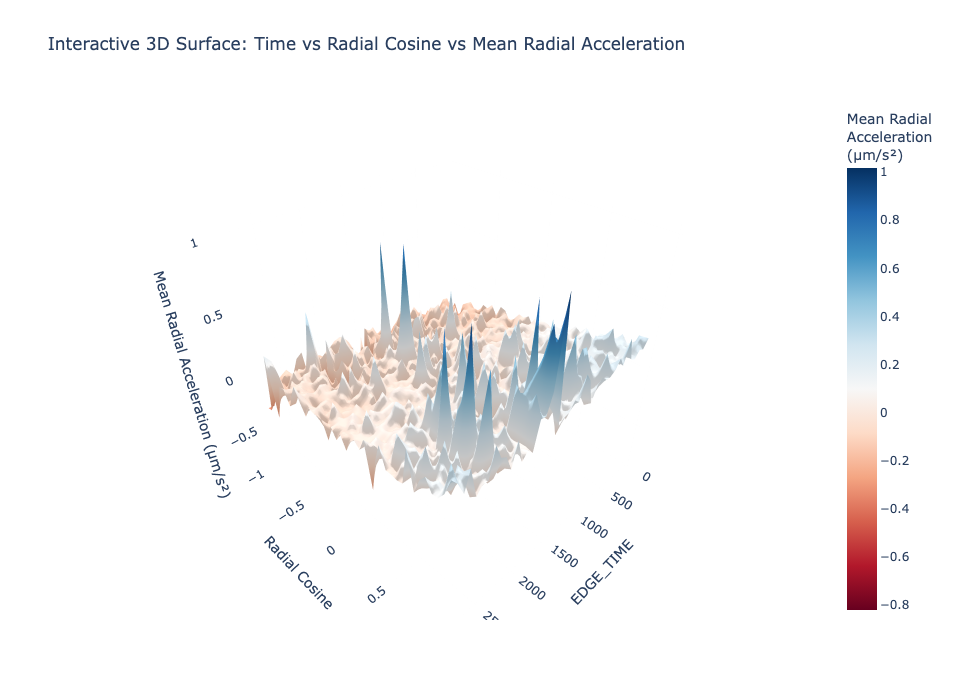

Time range: 1.5 to 2798.5
Radial cosine range: -1.000 to 1.000
Acceleration range: -2.5189 to 2.5591 μm/s²
Mean acceleration per bin range: -0.8196 to 1.0173 μm/s²


In [69]:
# Interactive 3D surface: Time vs Radial Cosine vs Mean Radial Acceleration
from utils import plot_interactive_acceleration_surface_3d

plot_interactive_acceleration_surface_3d(merged_sorted, n_time_bins=40, n_cos_bins=40)